### Paxillin movie segmentation and object feature analysis

with static images

Liya Ding, 2024.04

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import umap
from joblib import dump, load
import os.path

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.transforms import Bbox

import tifffile 
import czifile

import skimage
from skimage.morphology import remove_small_objects
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb

from scipy import ndimage
from scipy.ndimage import distance_transform_cdt
from scipy.ndimage import gaussian_filter

from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# function from aicssegmentation tool
from utils.vessel_2d import filament_2d_wrapper
from utils.pre_processing_utils import intensity_normalization


In [2]:
# build the colormap with iterative tab10
tab10 = cm.get_cmap('tab10', 10)
for i in range(10):
    tab10.colors = np.concatenate([tab10.colors,tab10.colors],axis=0)    
tab10.colors = np.concatenate([np.zeros([1,4]),tab10.colors],axis=0)

newmap = cm.get_cmap('tab10', 4000+1)
newmap.colors = tab10.colors[0:4000+1,:]
newmap.colors[0,:]  = np.zeros([1,4])
newmap.colors[0,3] = 1

In [3]:
newmap.colors


array([[0.        , 0.        , 0.        , 1.        ],
       [0.12156863, 0.46666667, 0.70588235, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       ...,
       [0.49803922, 0.49803922, 0.49803922, 1.        ],
       [0.7372549 , 0.74117647, 0.13333333, 1.        ],
       [0.09019608, 0.74509804, 0.81176471, 1.        ]])

### for each movie run through all the time points

In [4]:
prop_df_pax_all=pd.read_csv(os.path.join('/mnt/d/lding/FA/analysis_results/static_image_csv/','static_images_cluster_labels_allcells_nc7.csv'))
        

In [5]:
columns=['area', 'bbox_area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number',
                    'extent','filled_area','label','major_axis_length','max_intensity','mean_intensity',
                    'min_intensity','minor_axis_length','orientation','perimeter','solidity',
                    'cell_edge_dist','cell_edge_orient','diff_orient']

/home/lding/anaconda3/envs/aics_segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


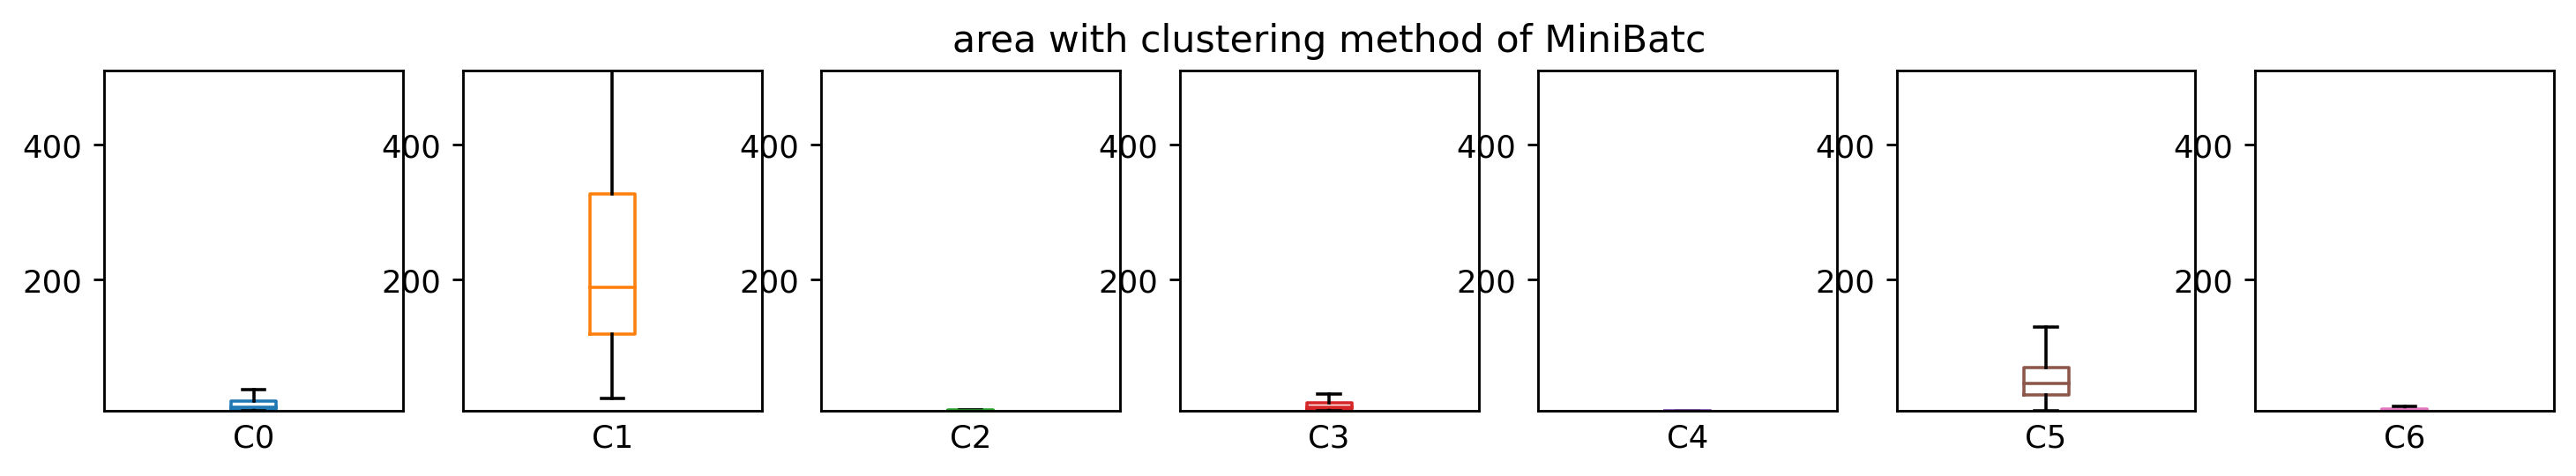

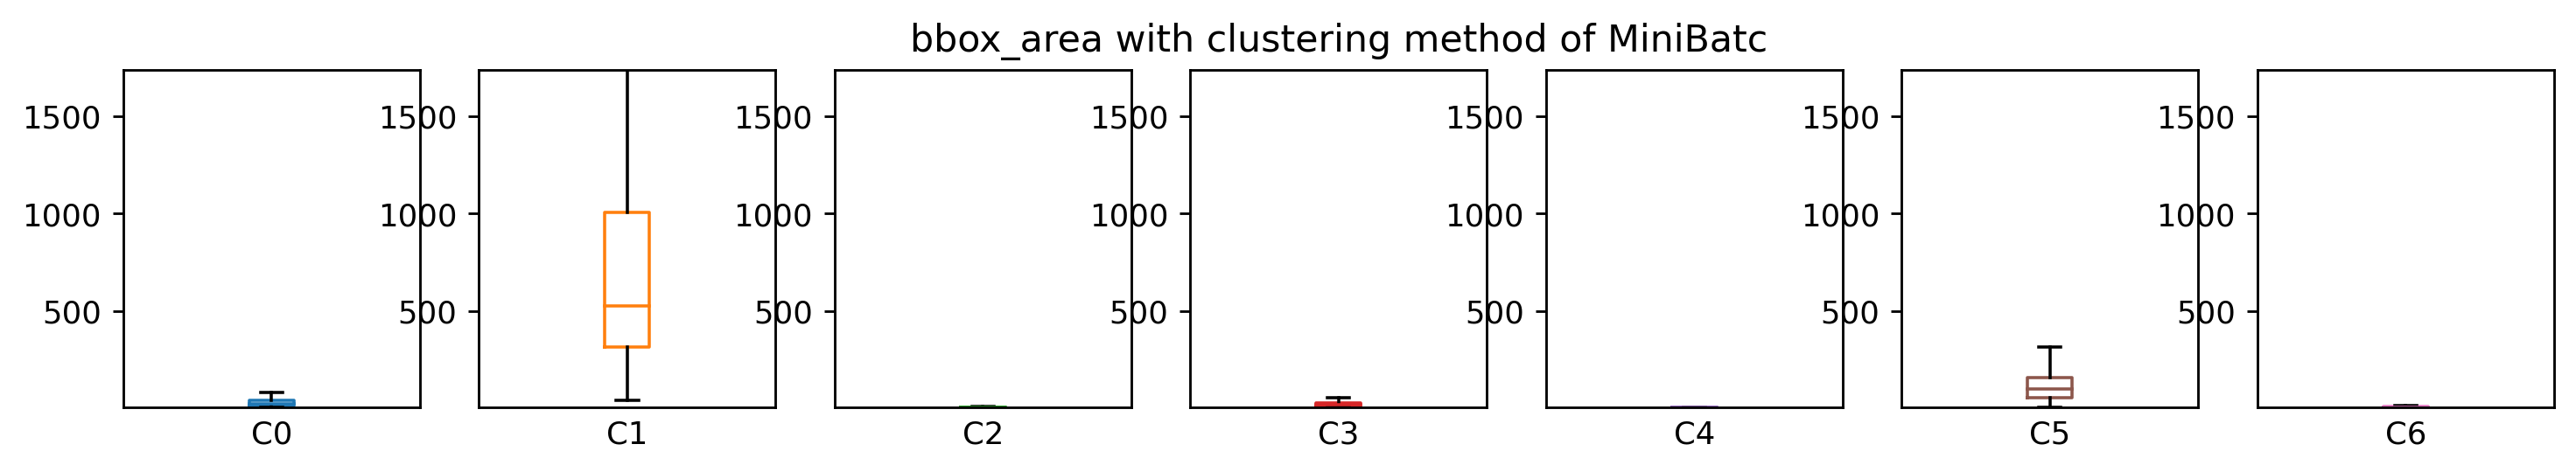

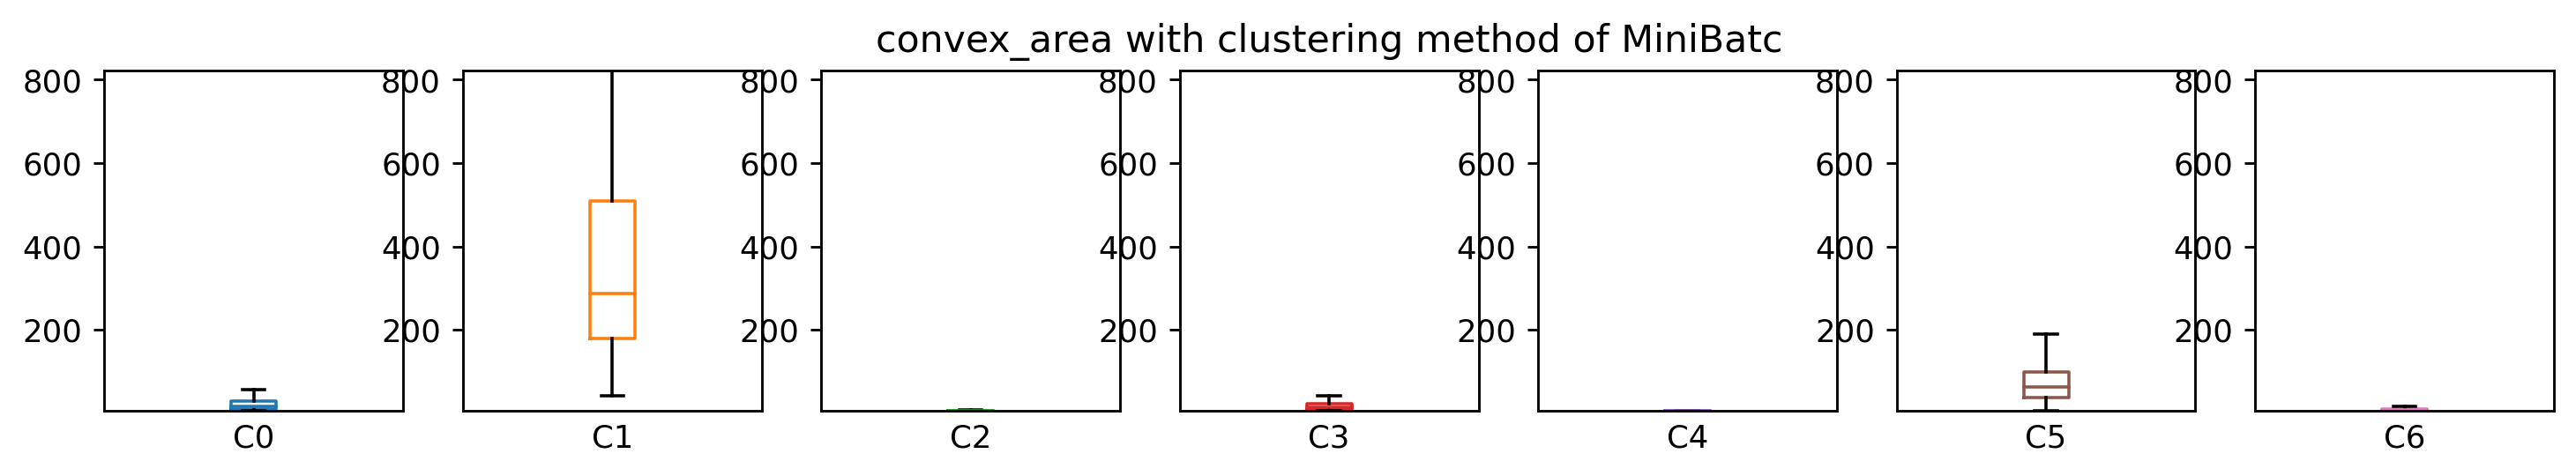

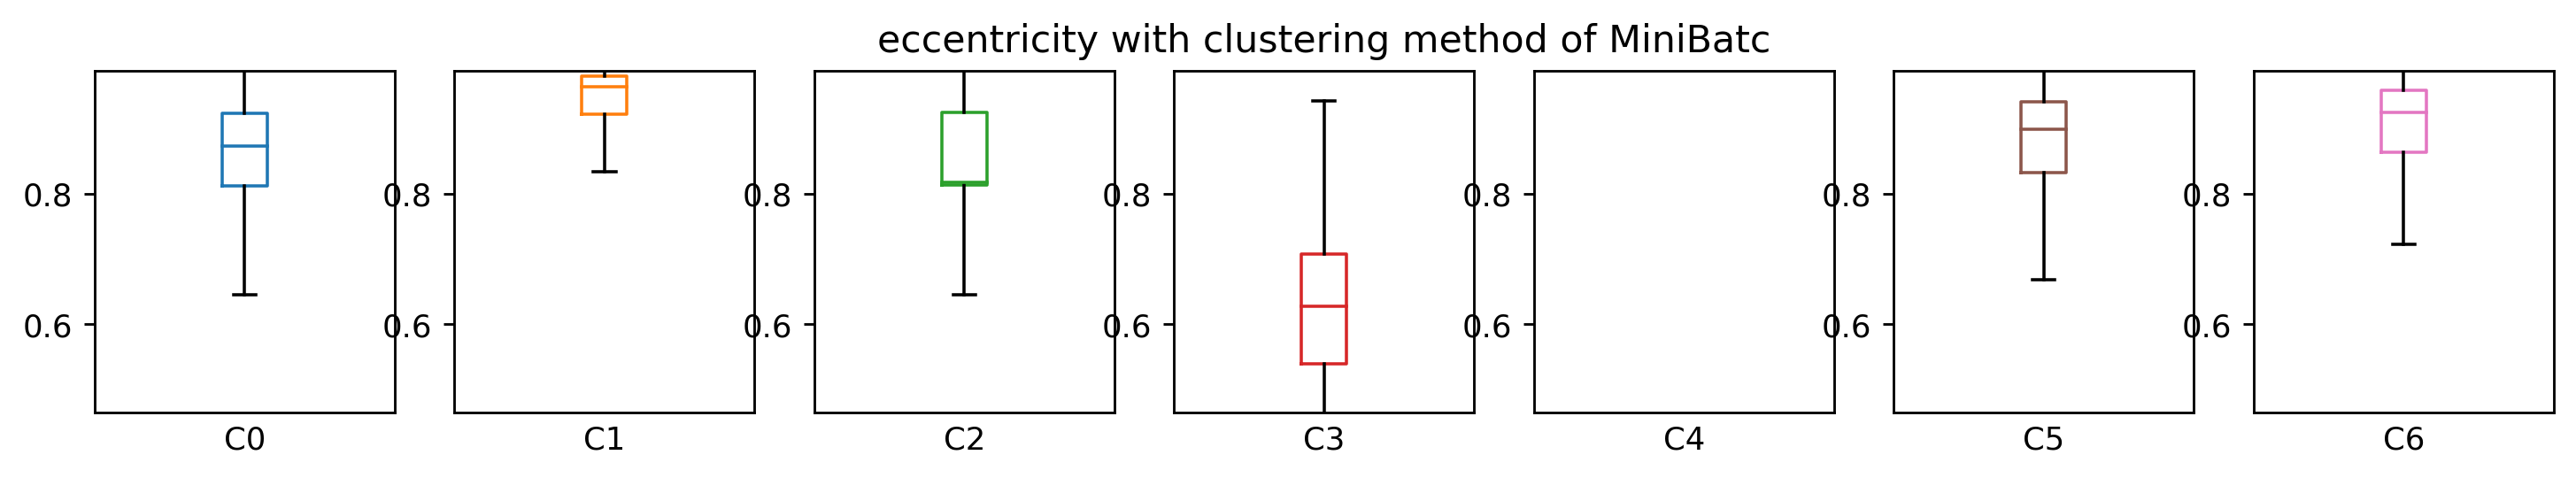

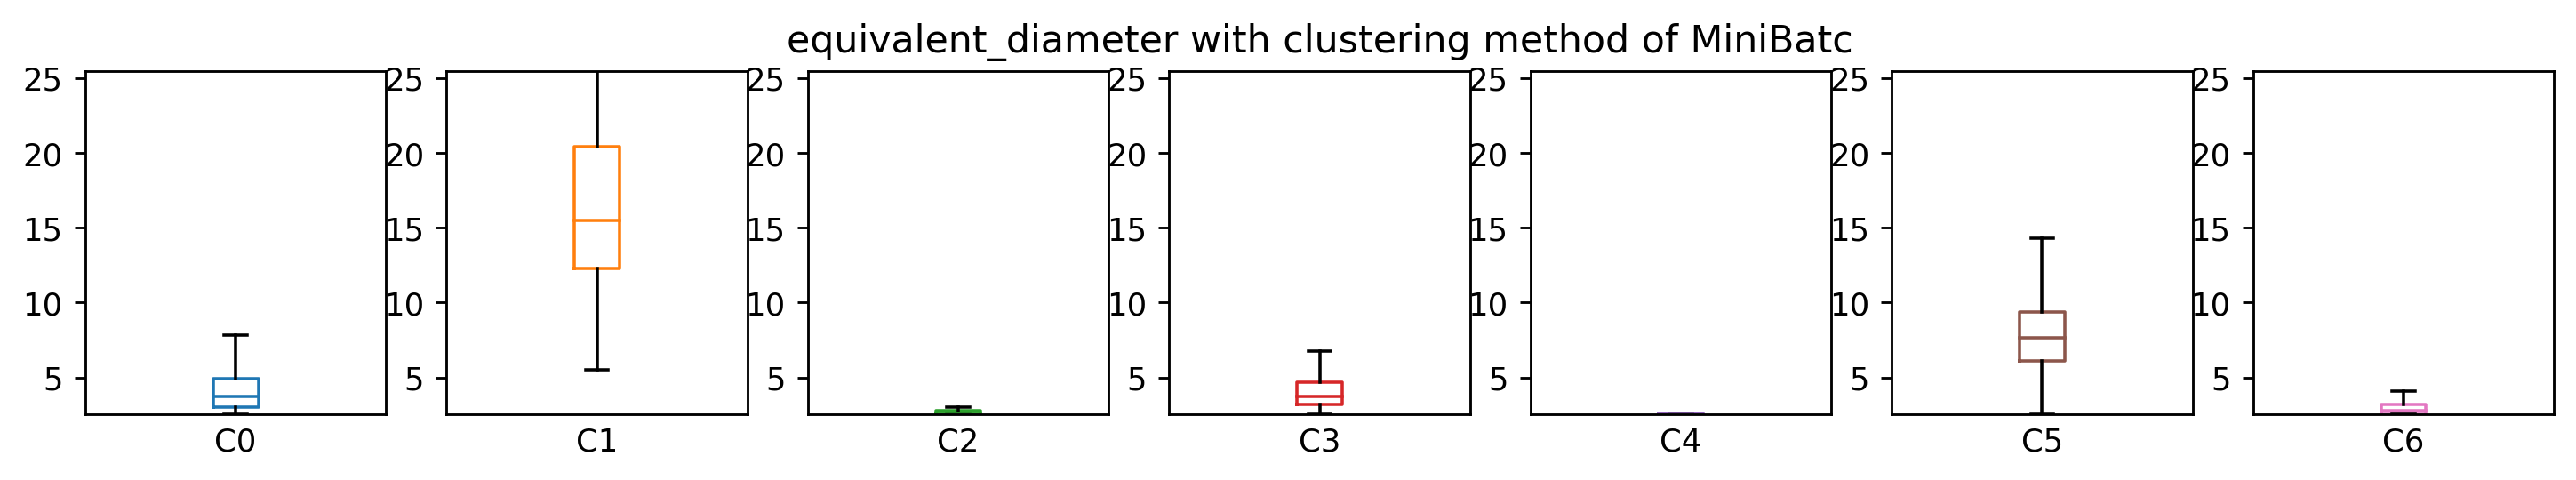

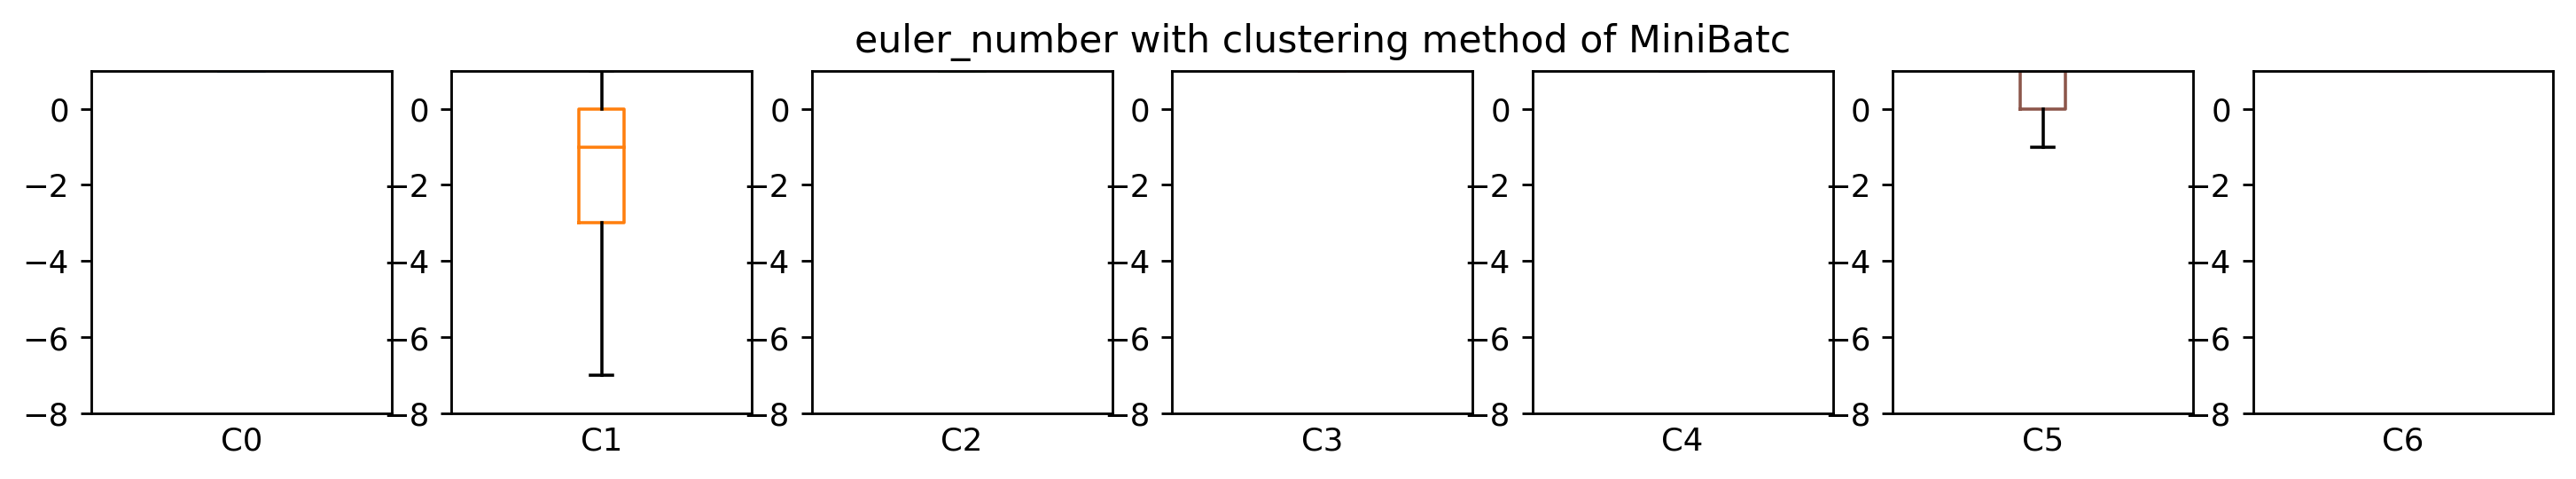

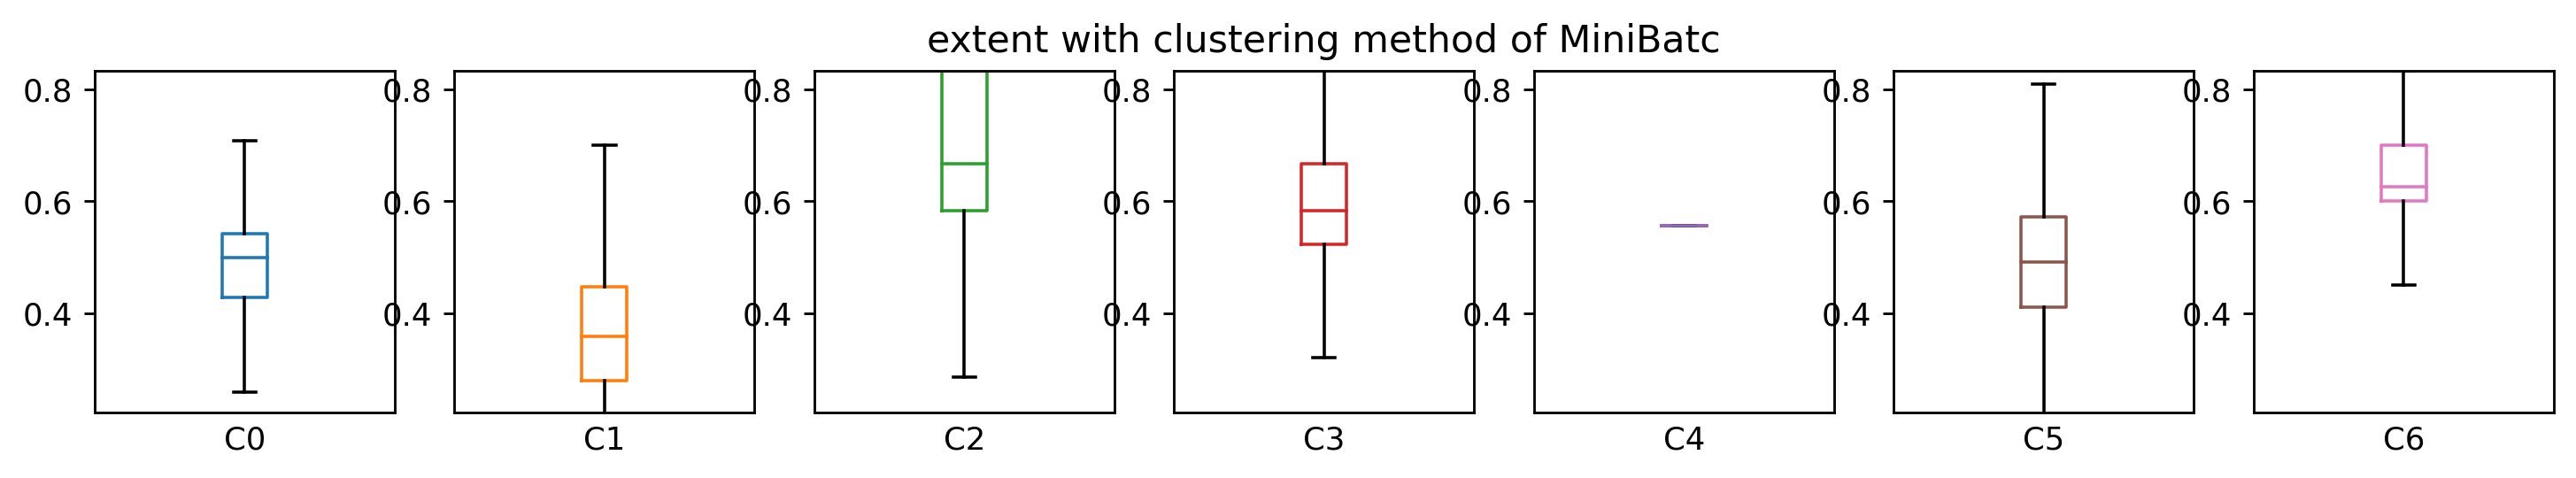

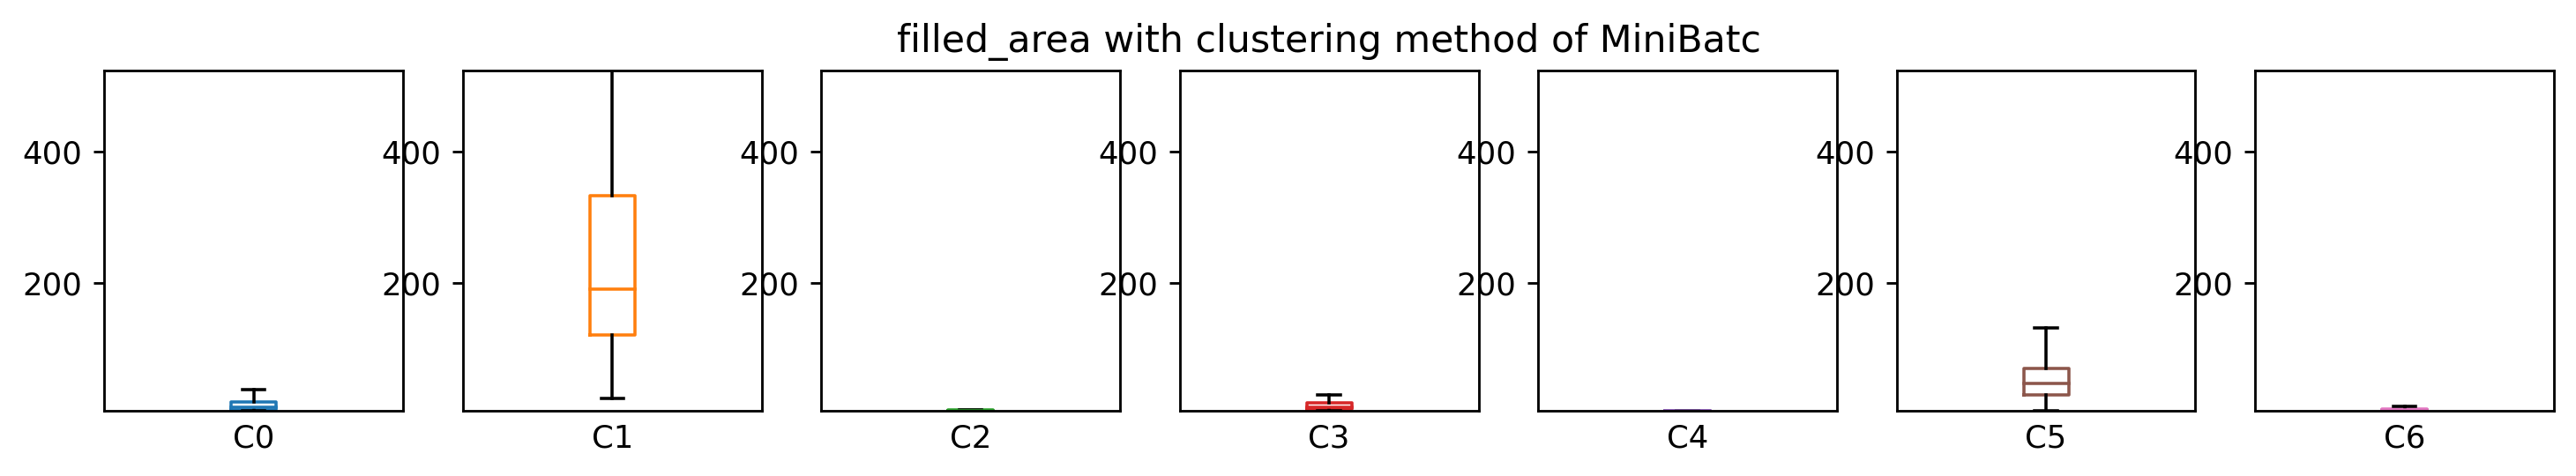

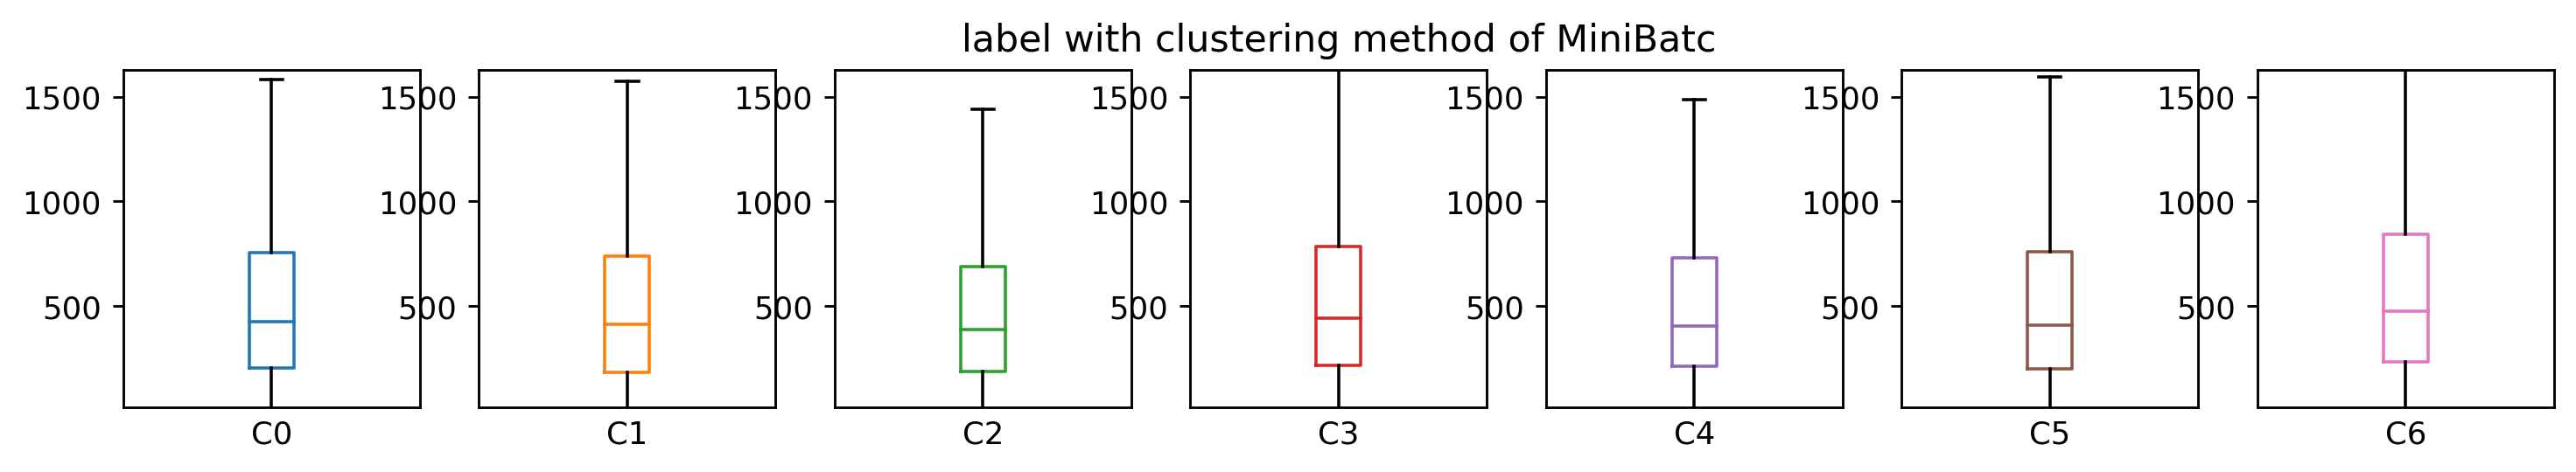

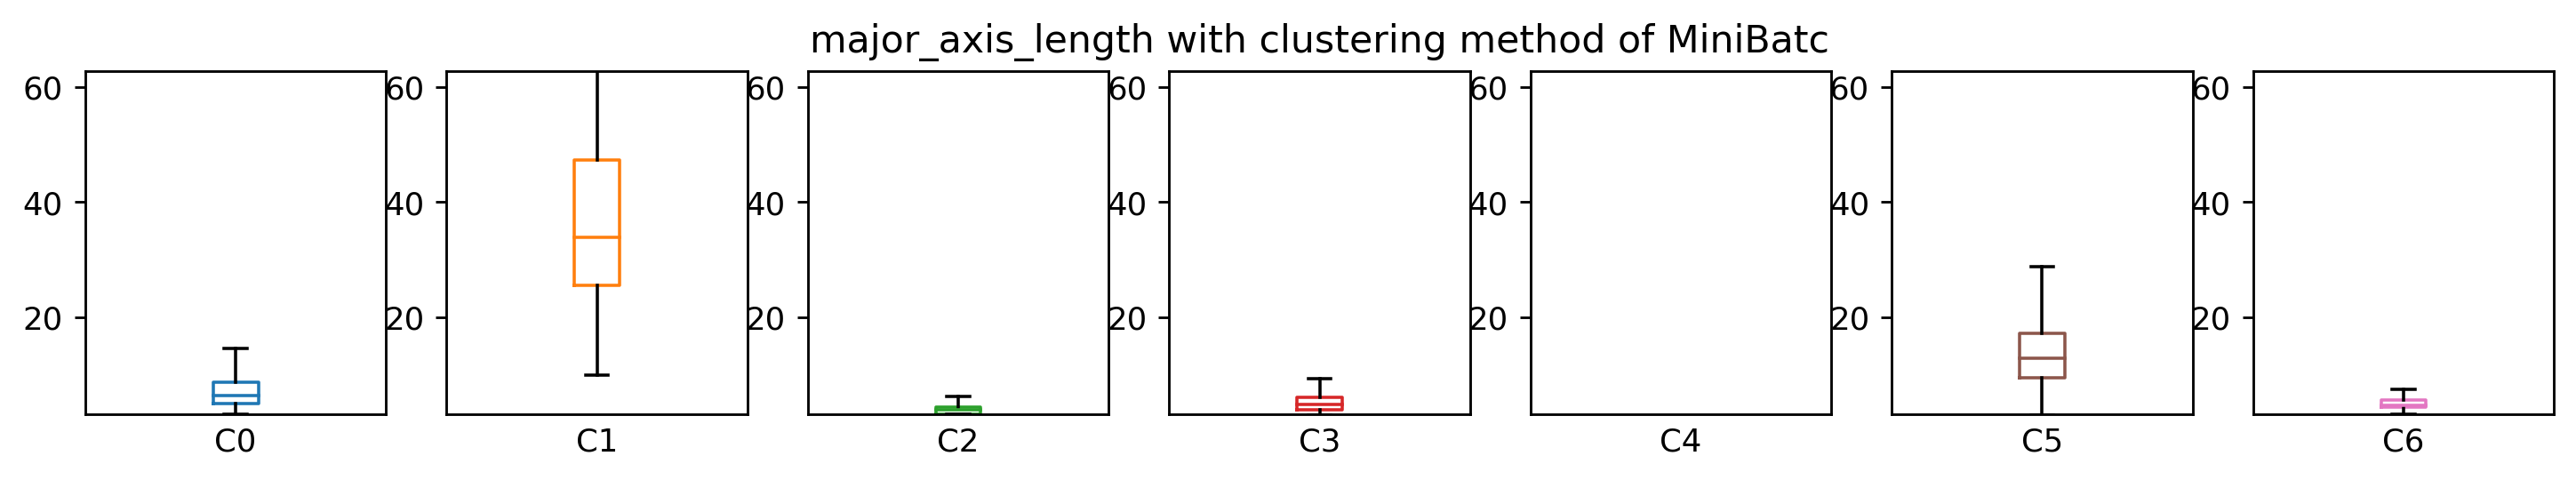

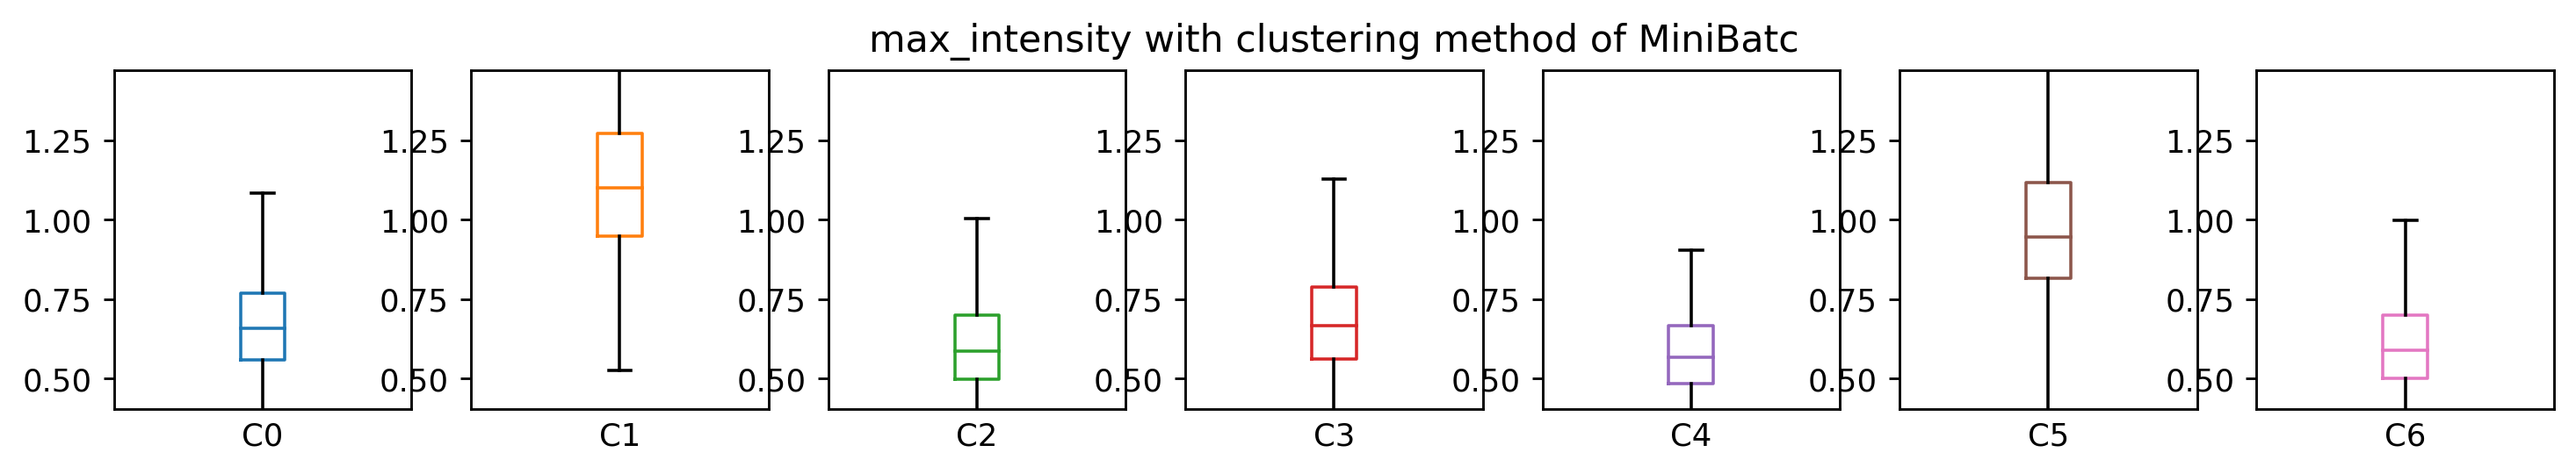

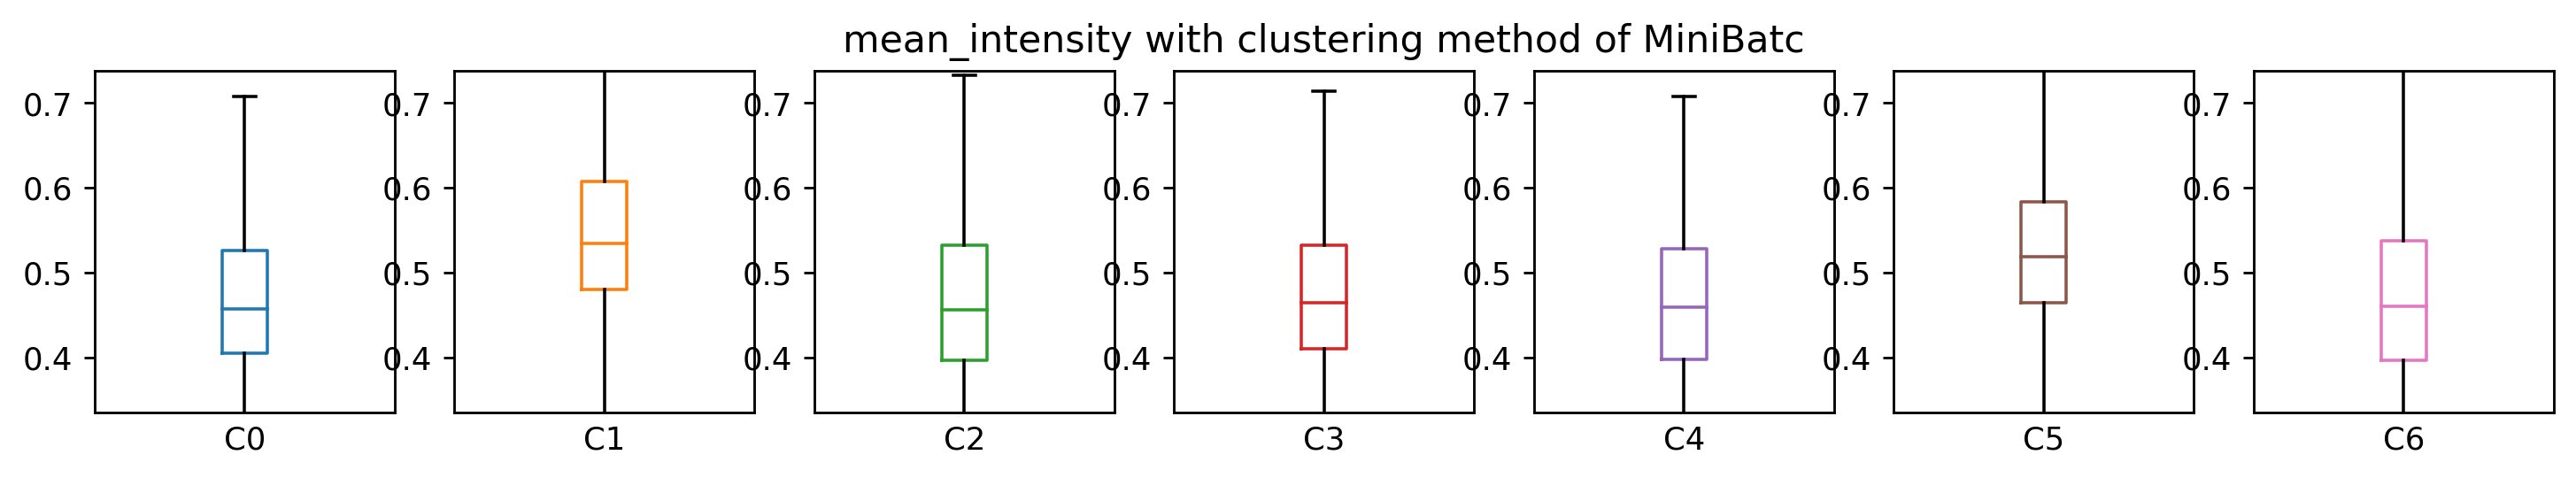

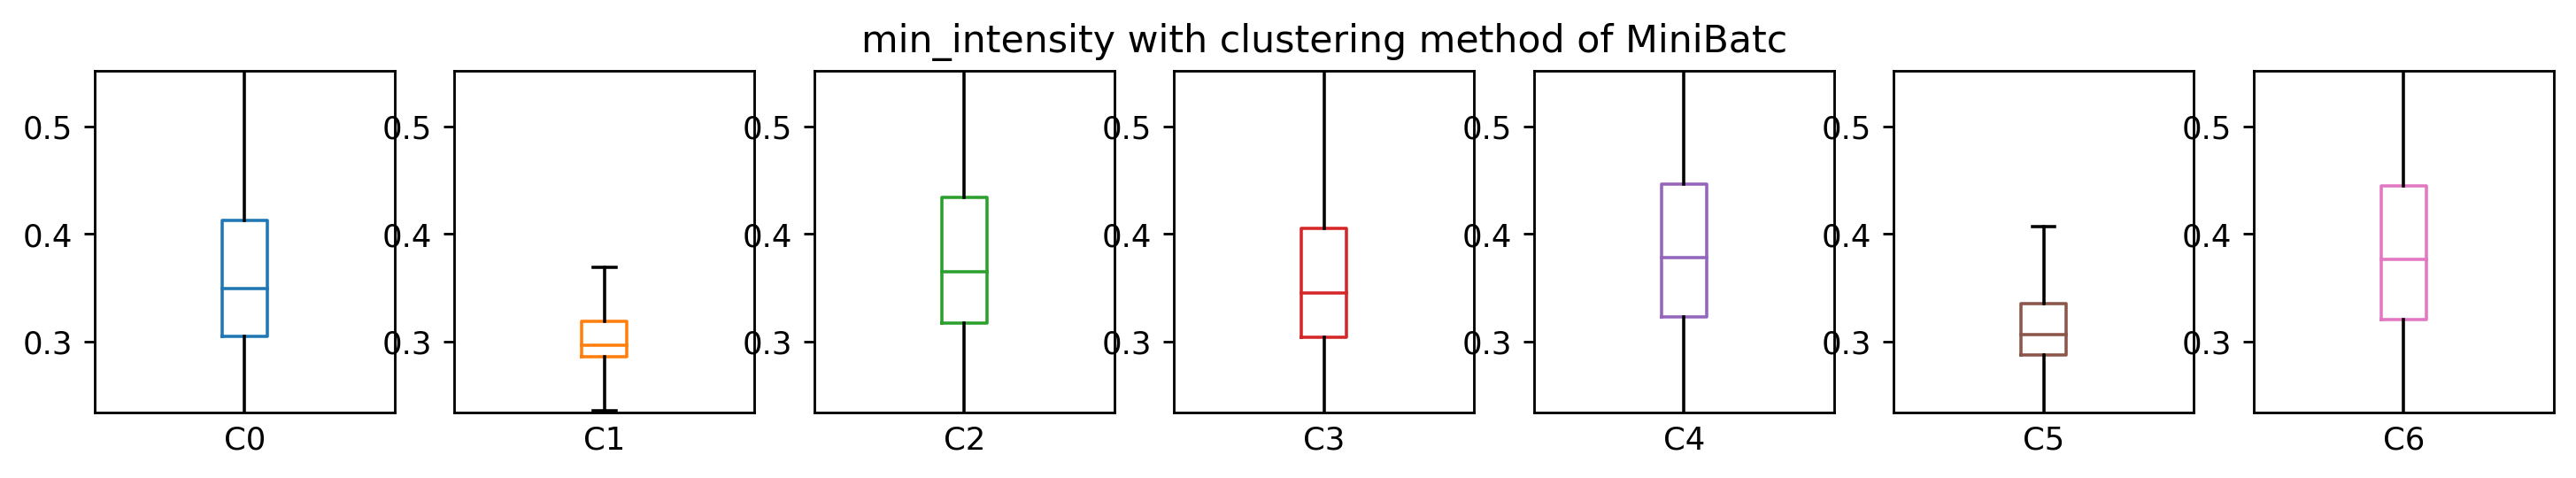

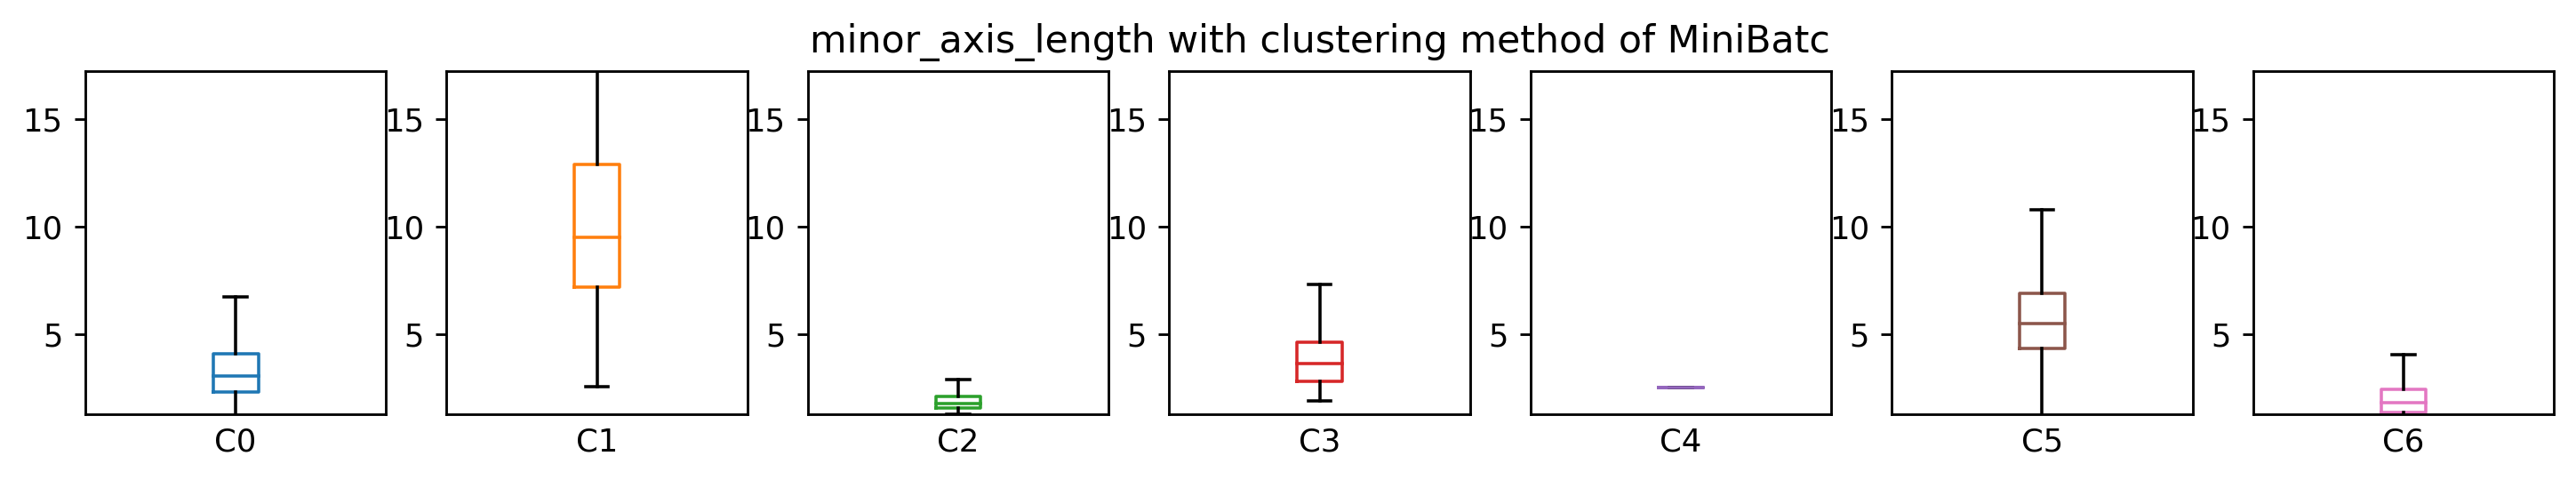

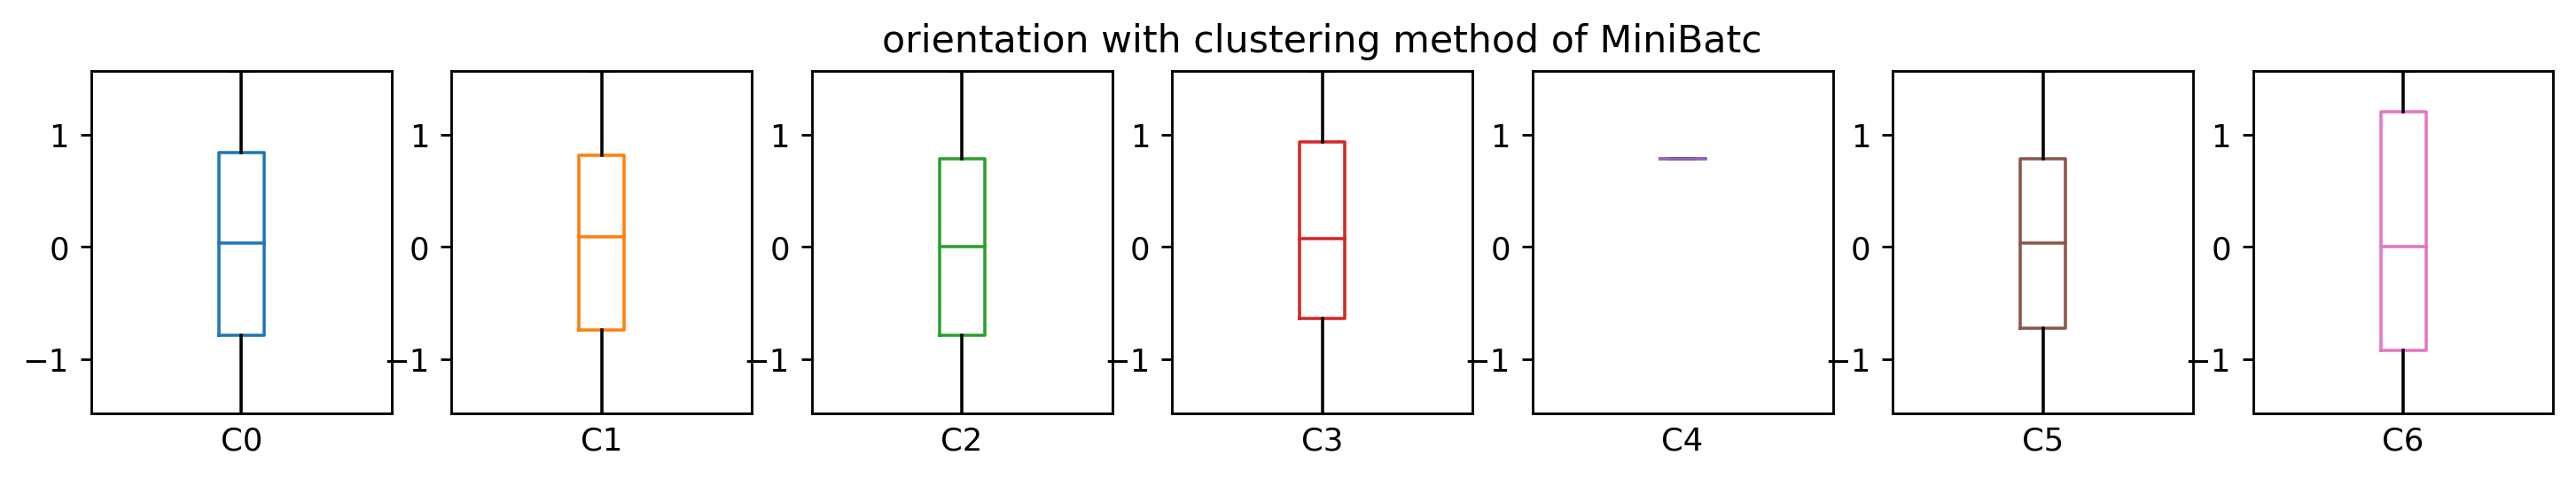

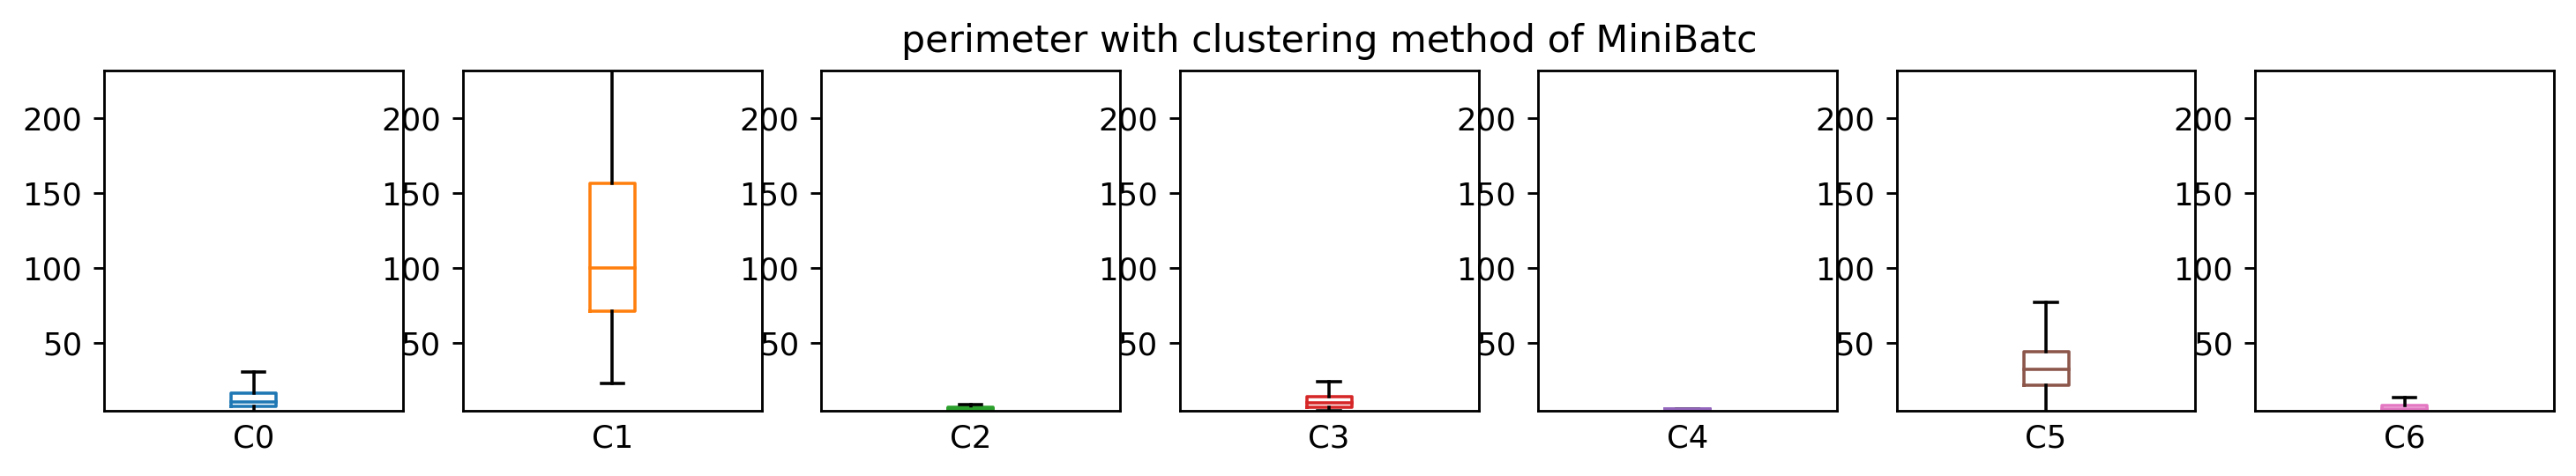

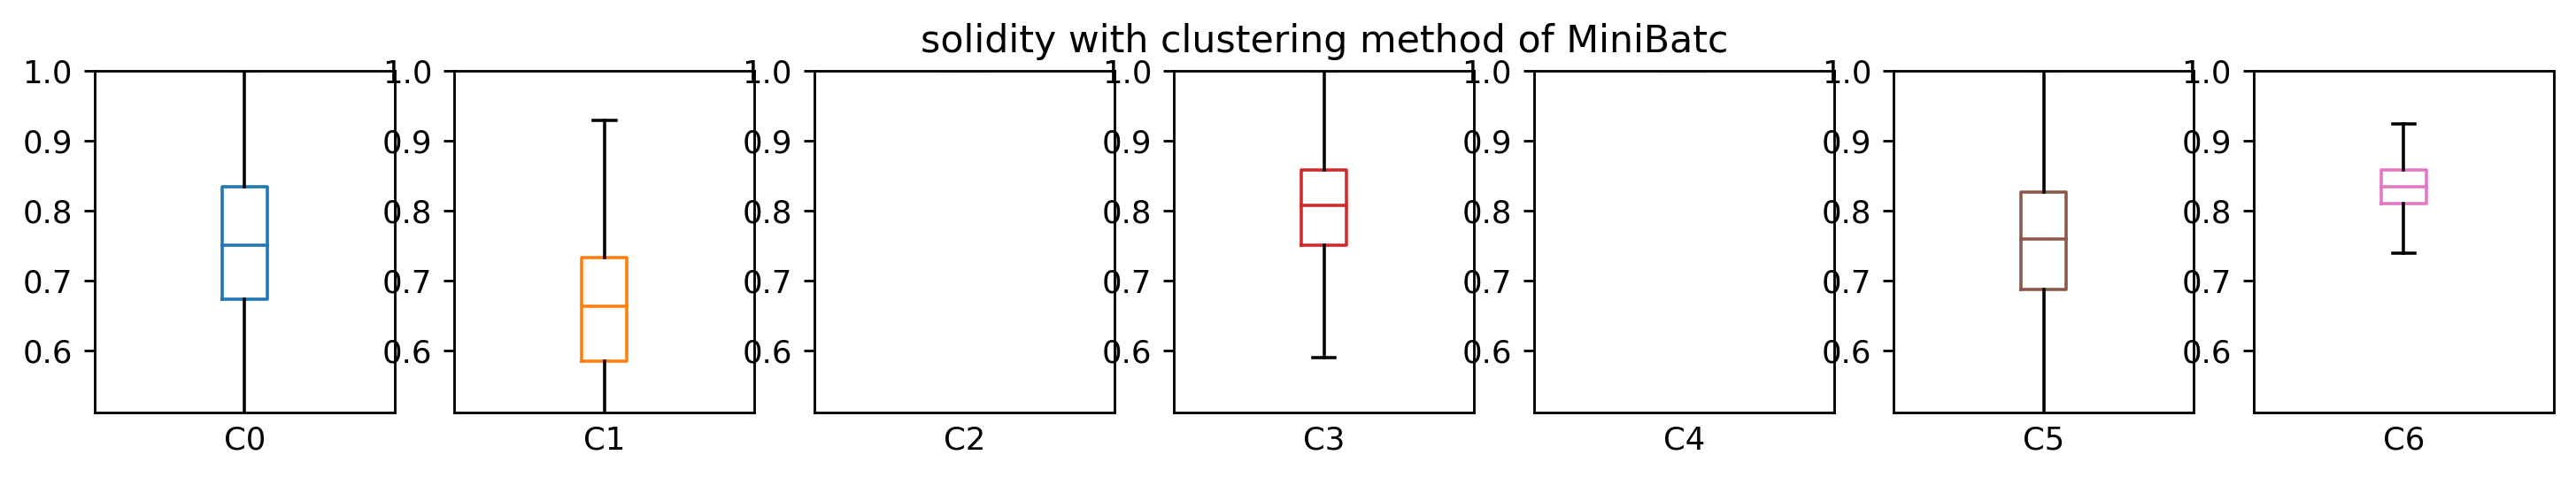

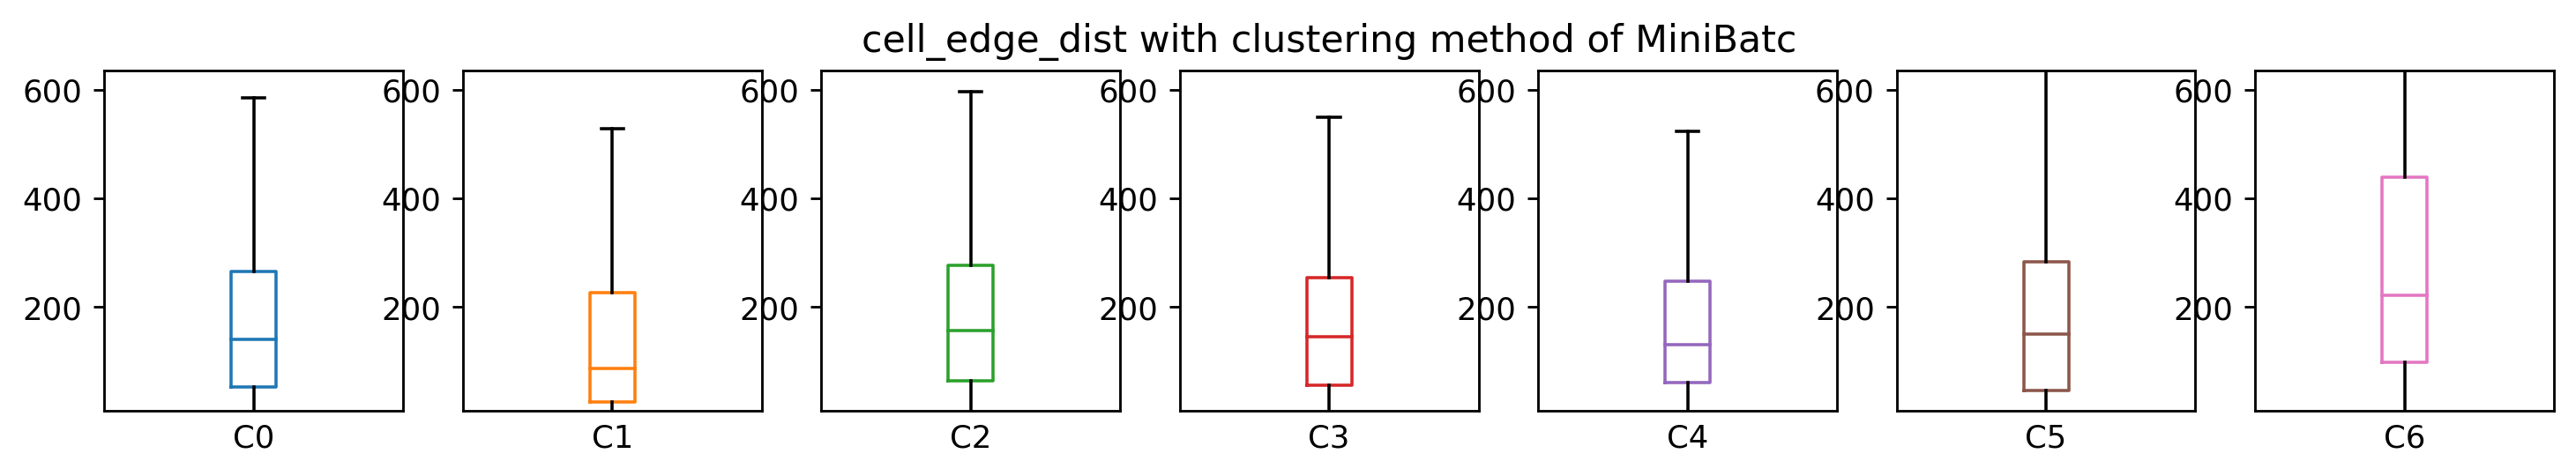

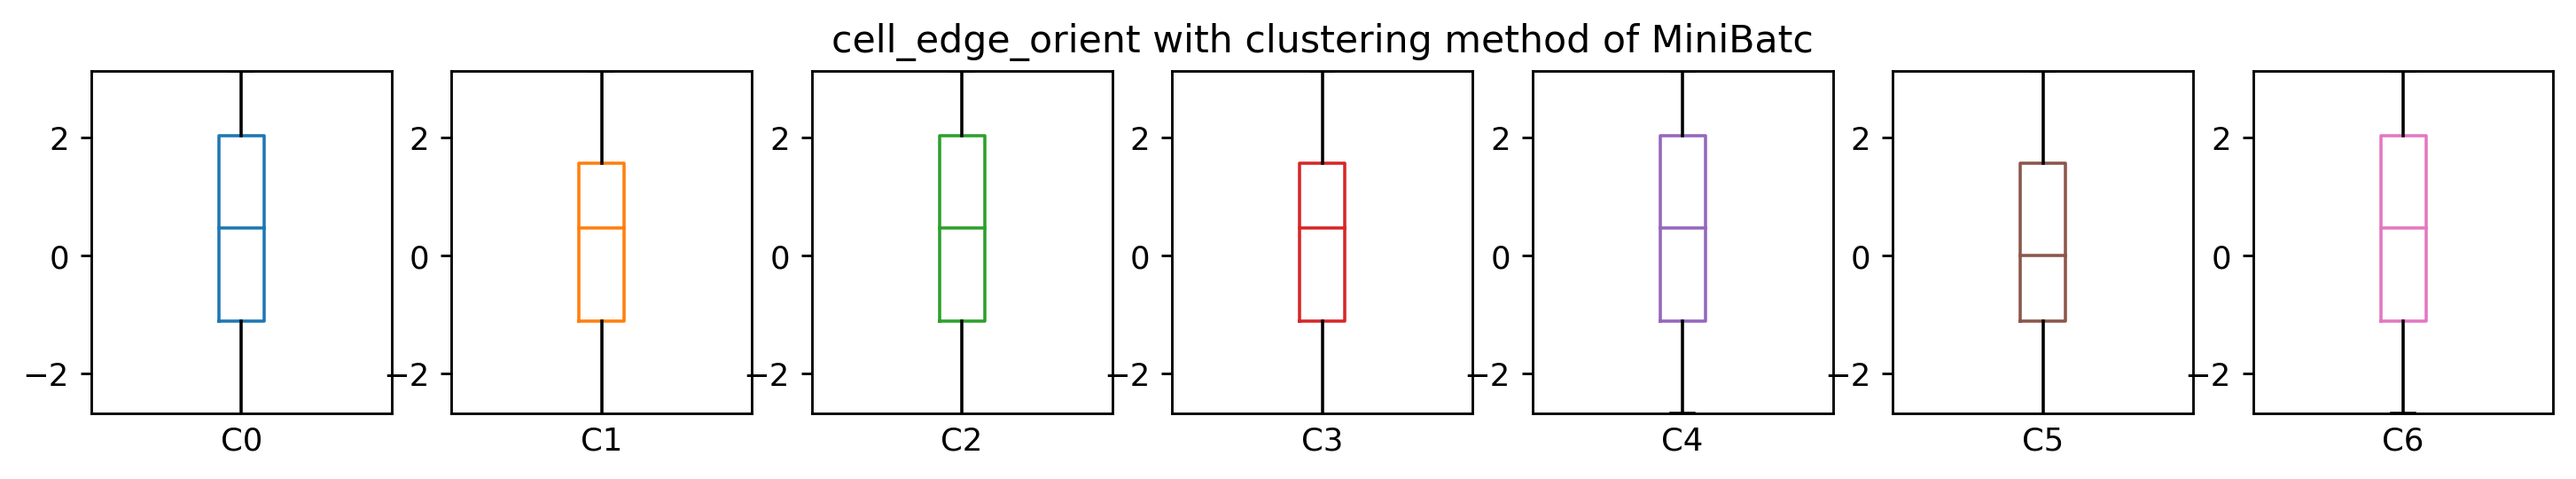

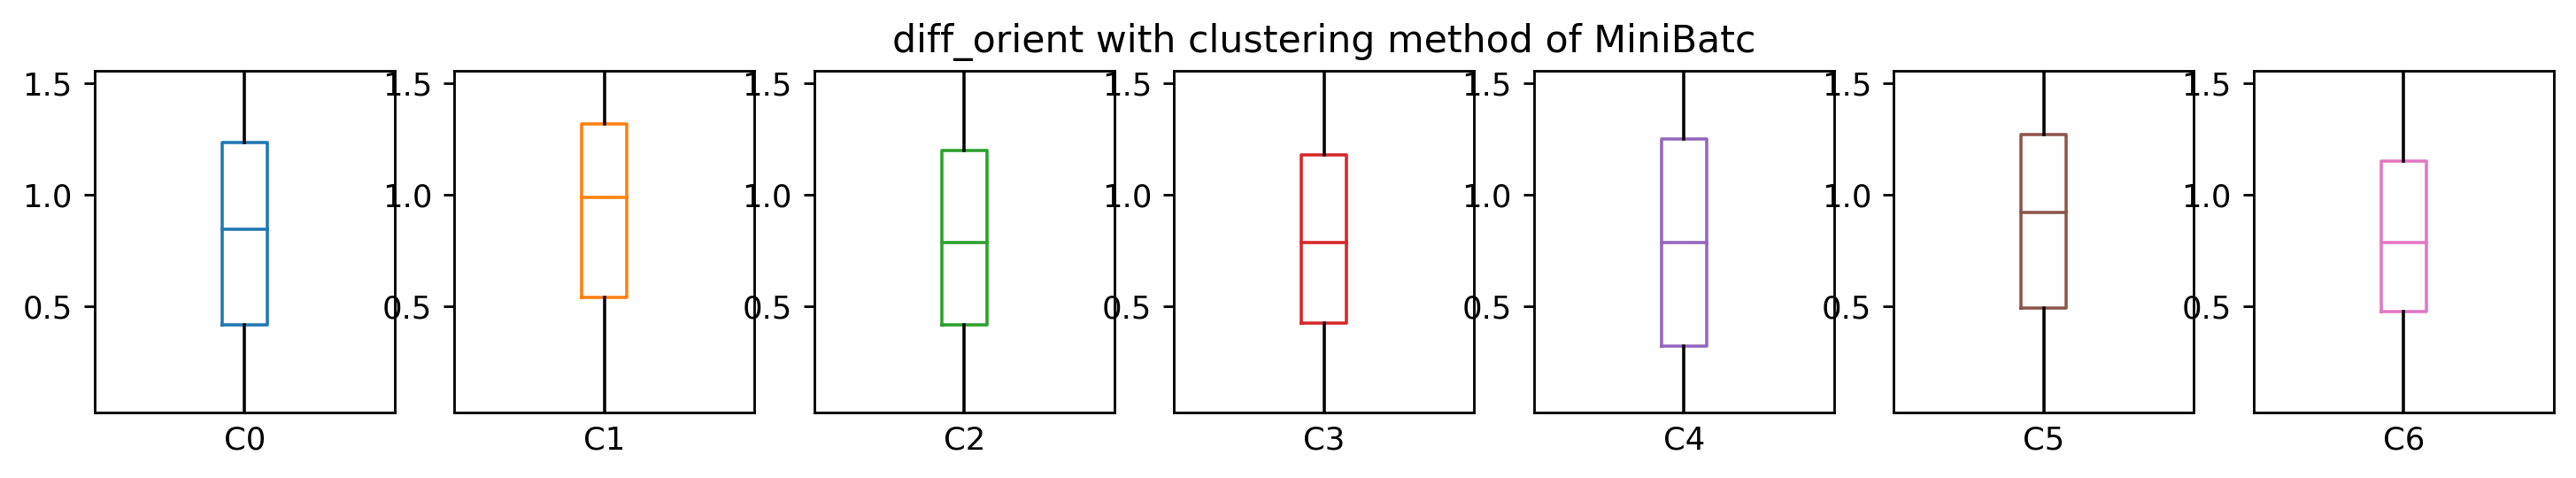

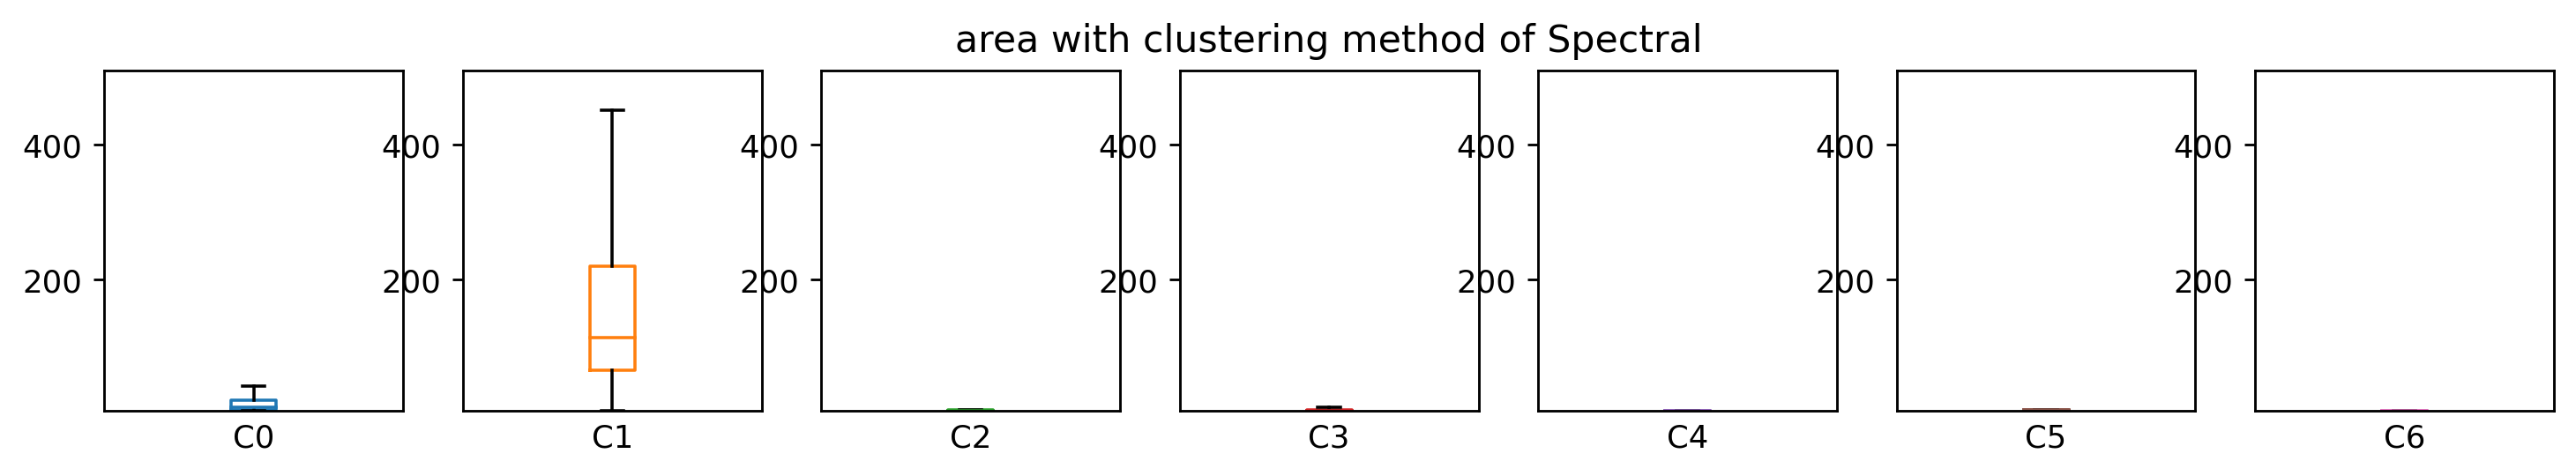

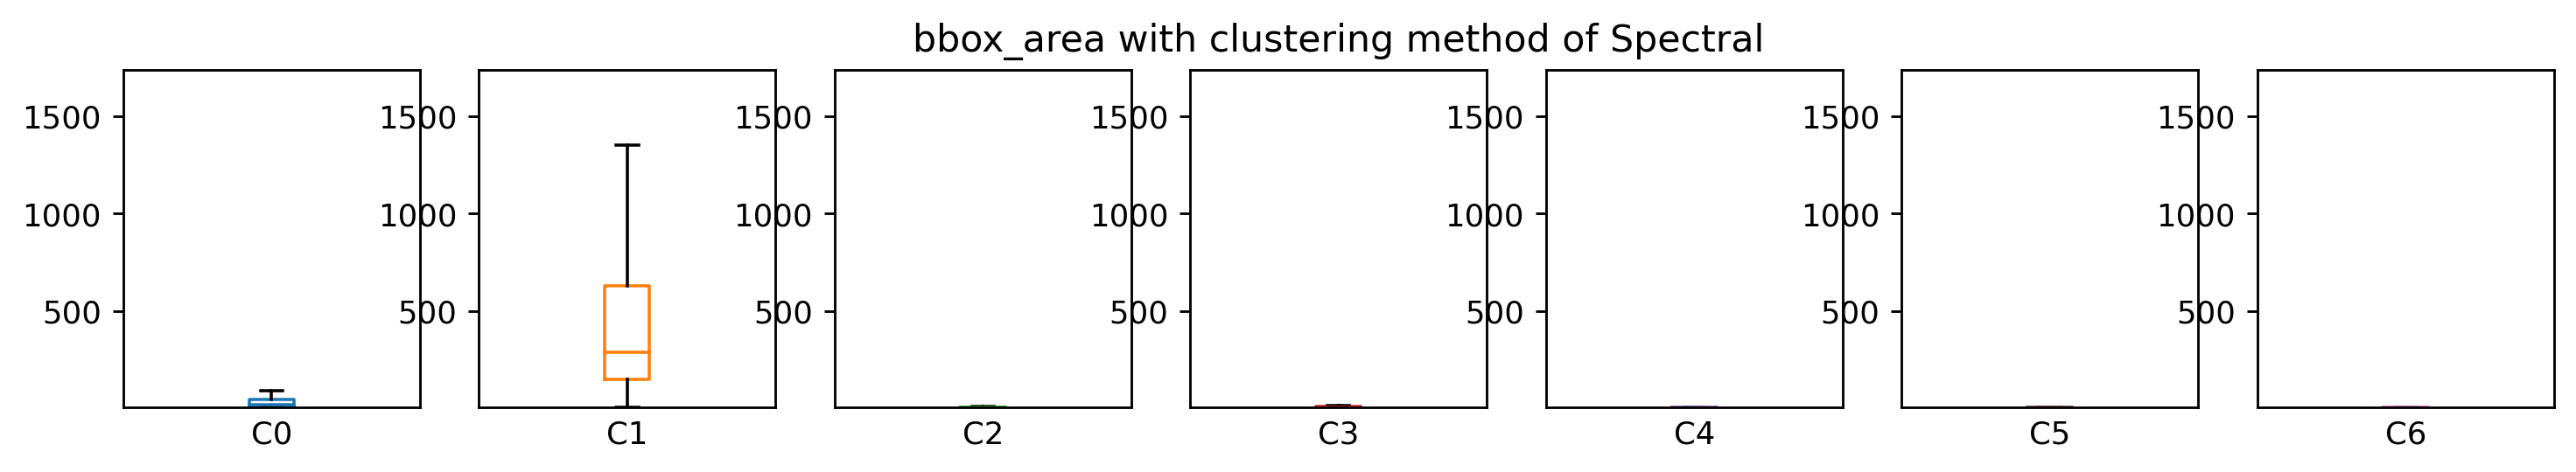

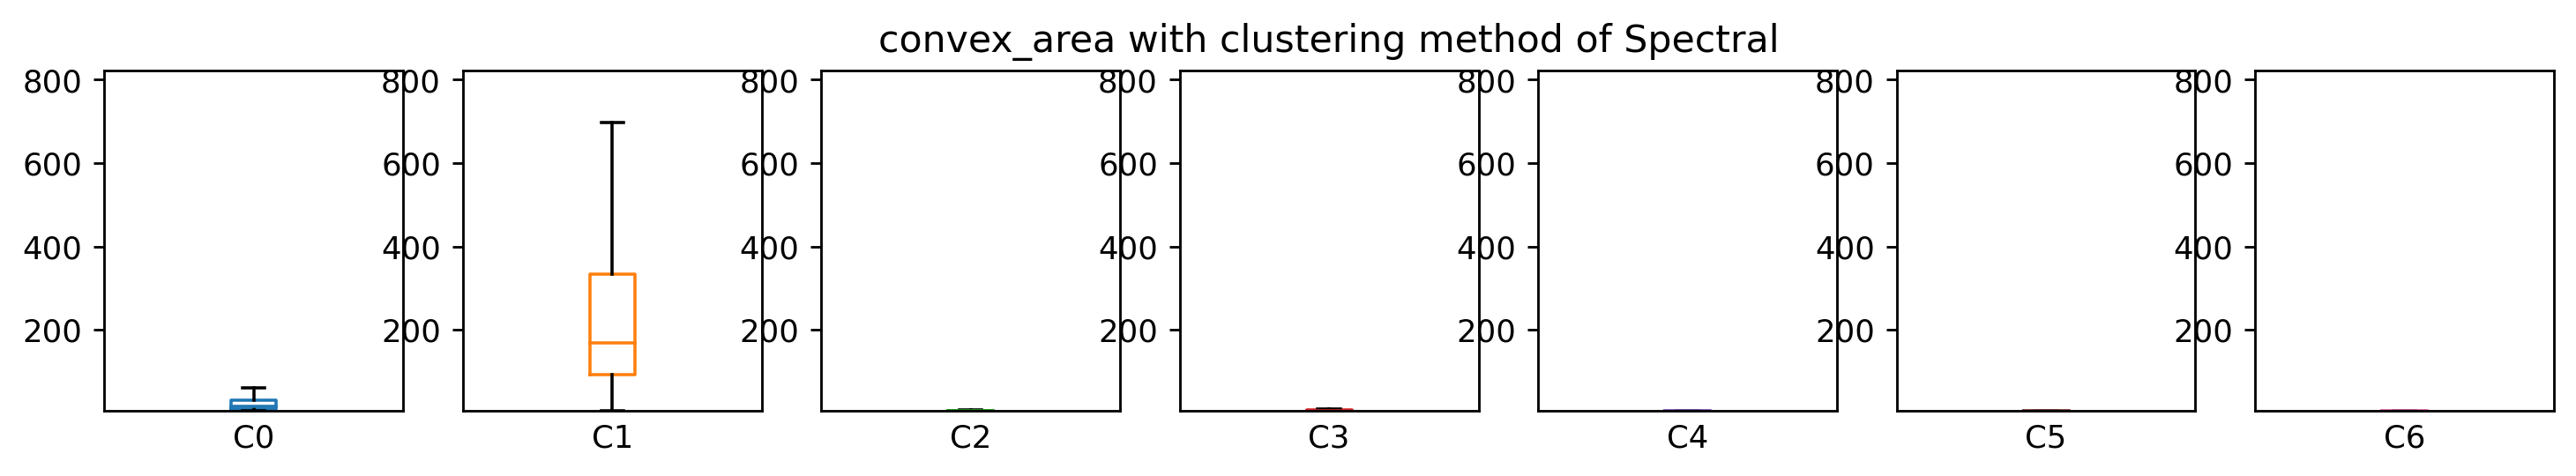

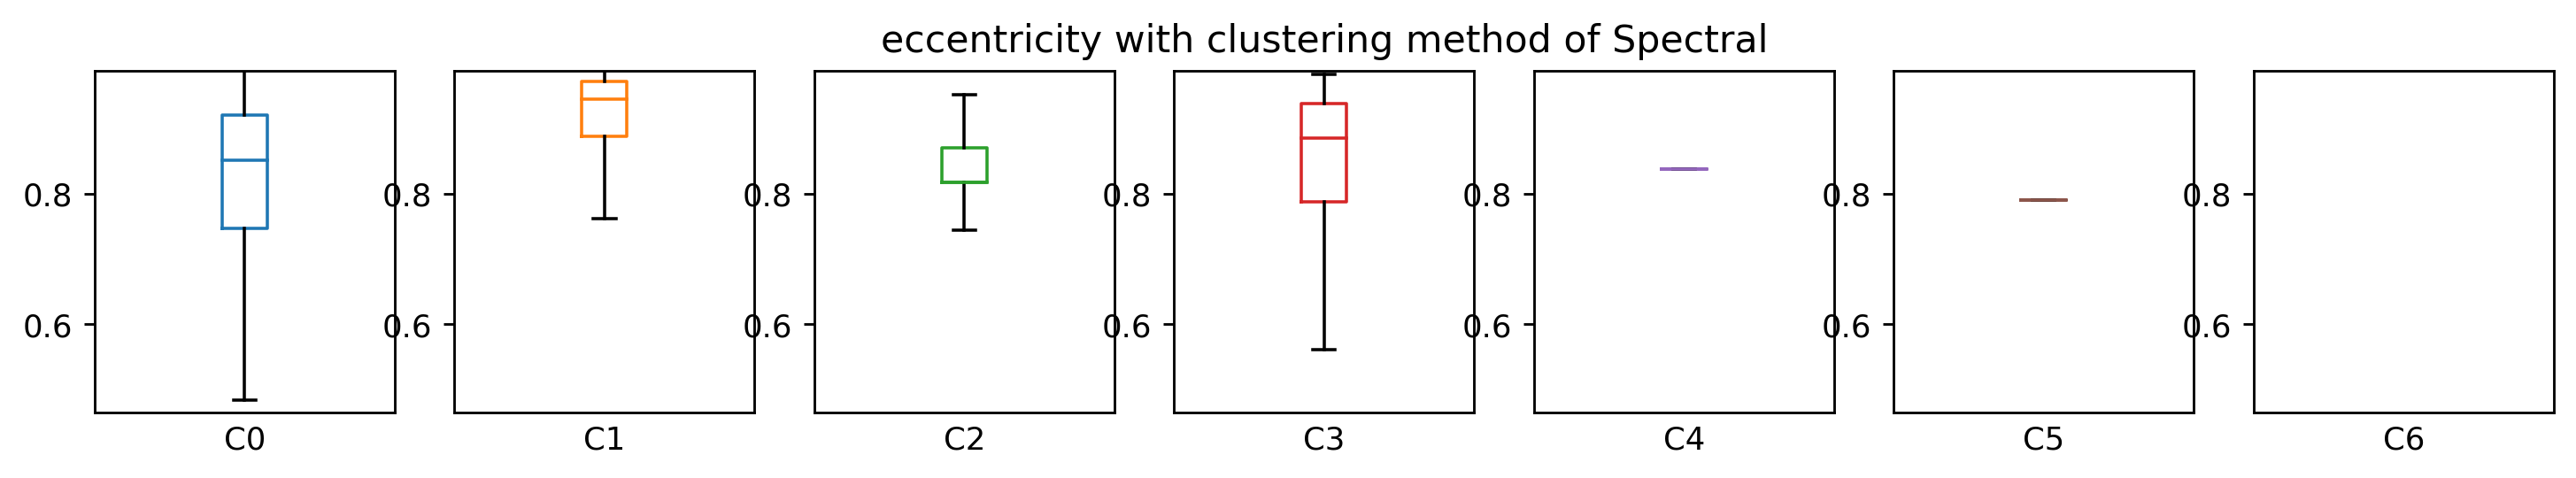

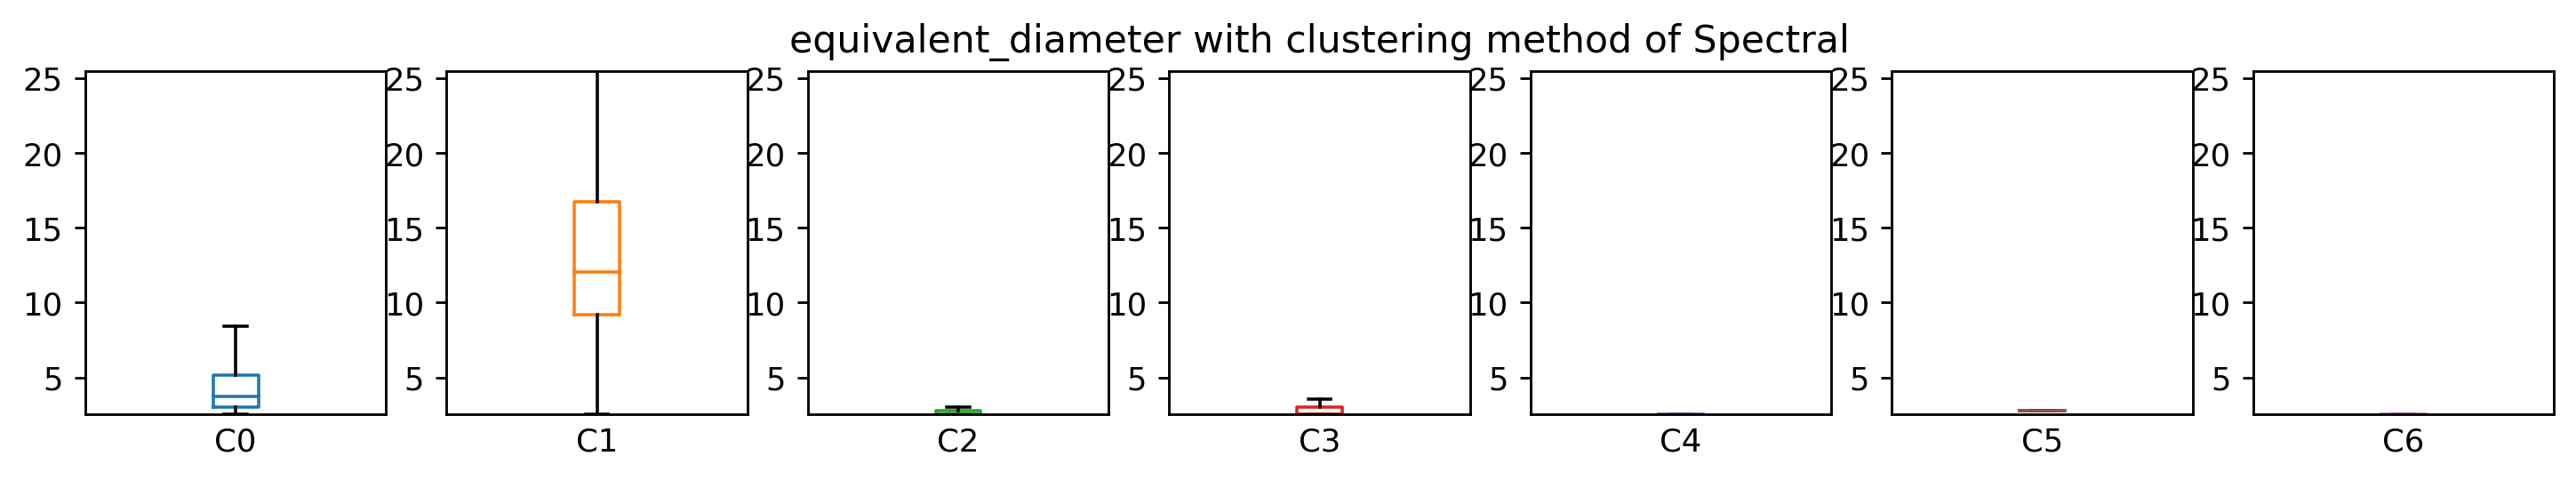

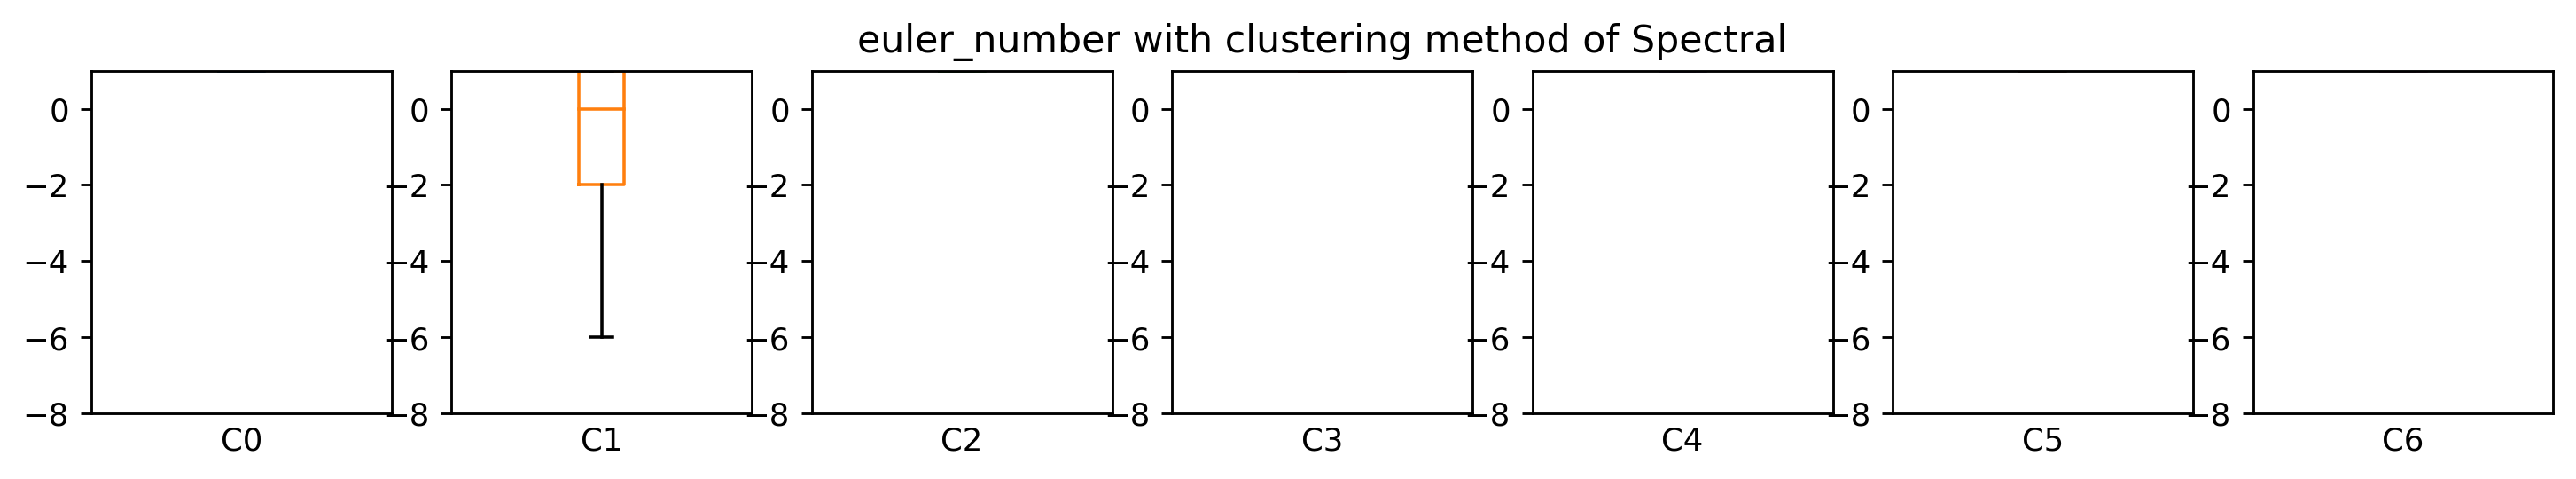

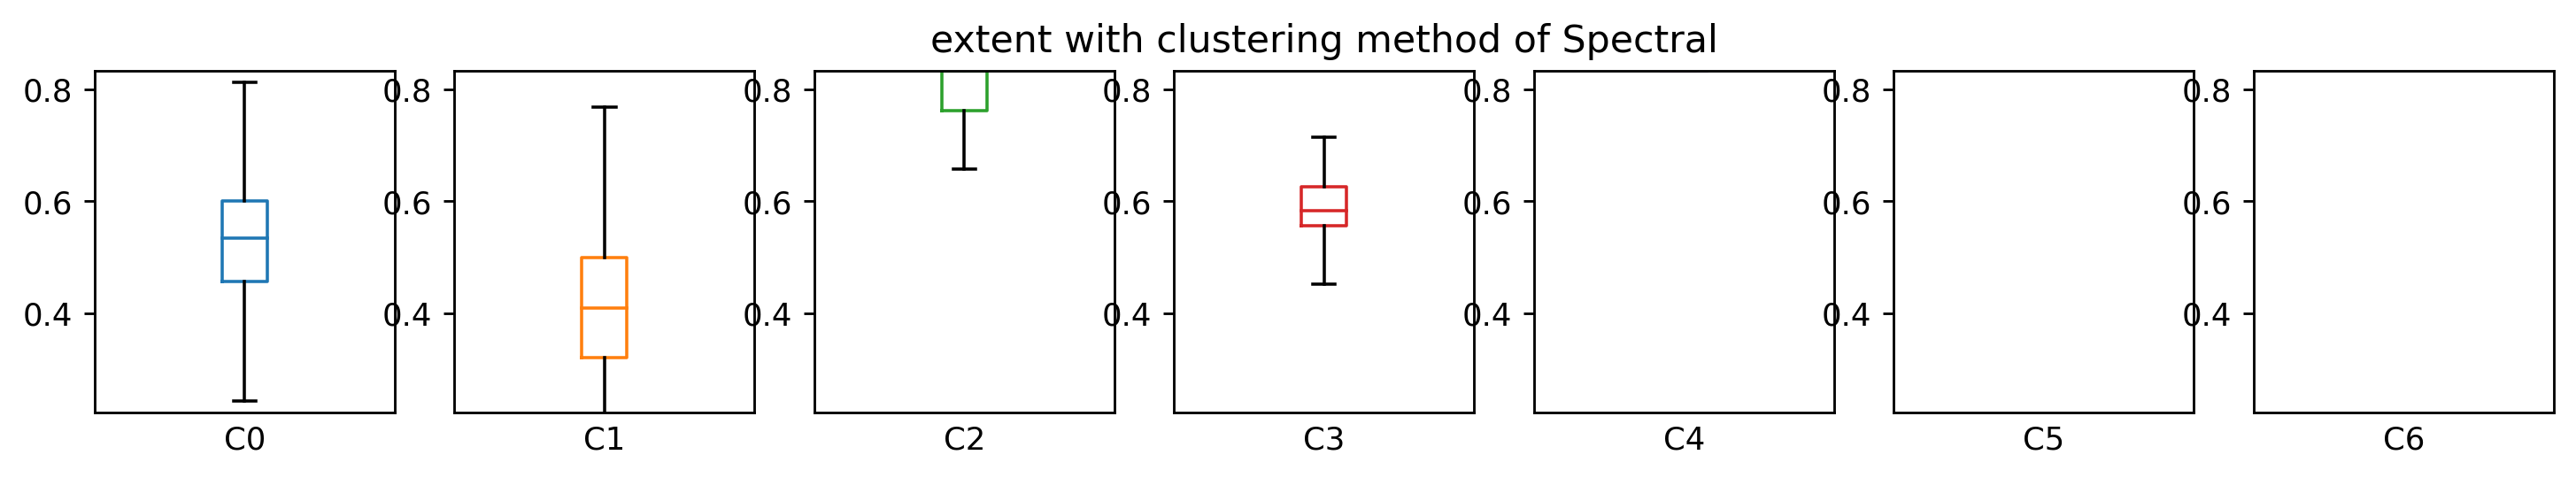

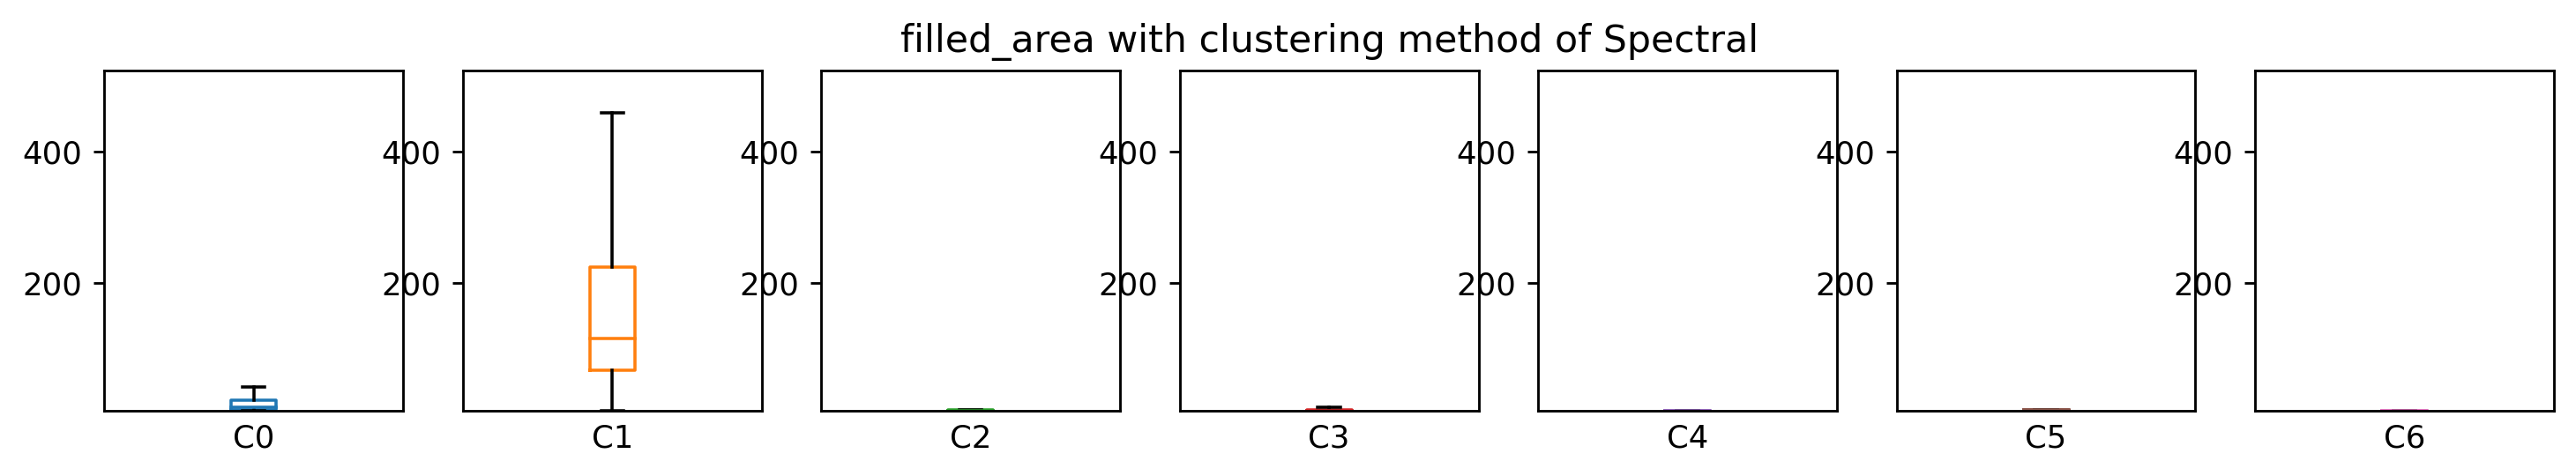

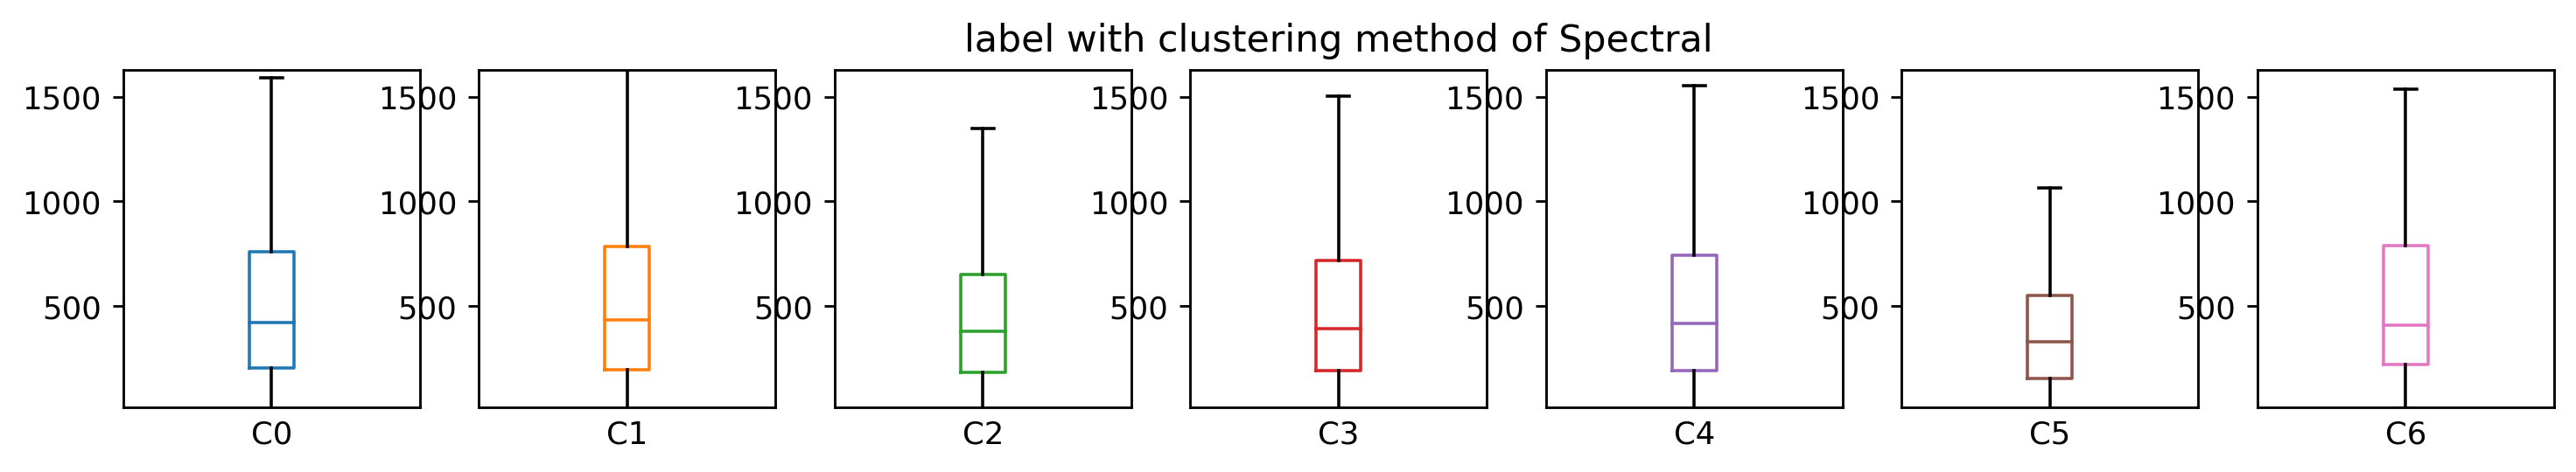

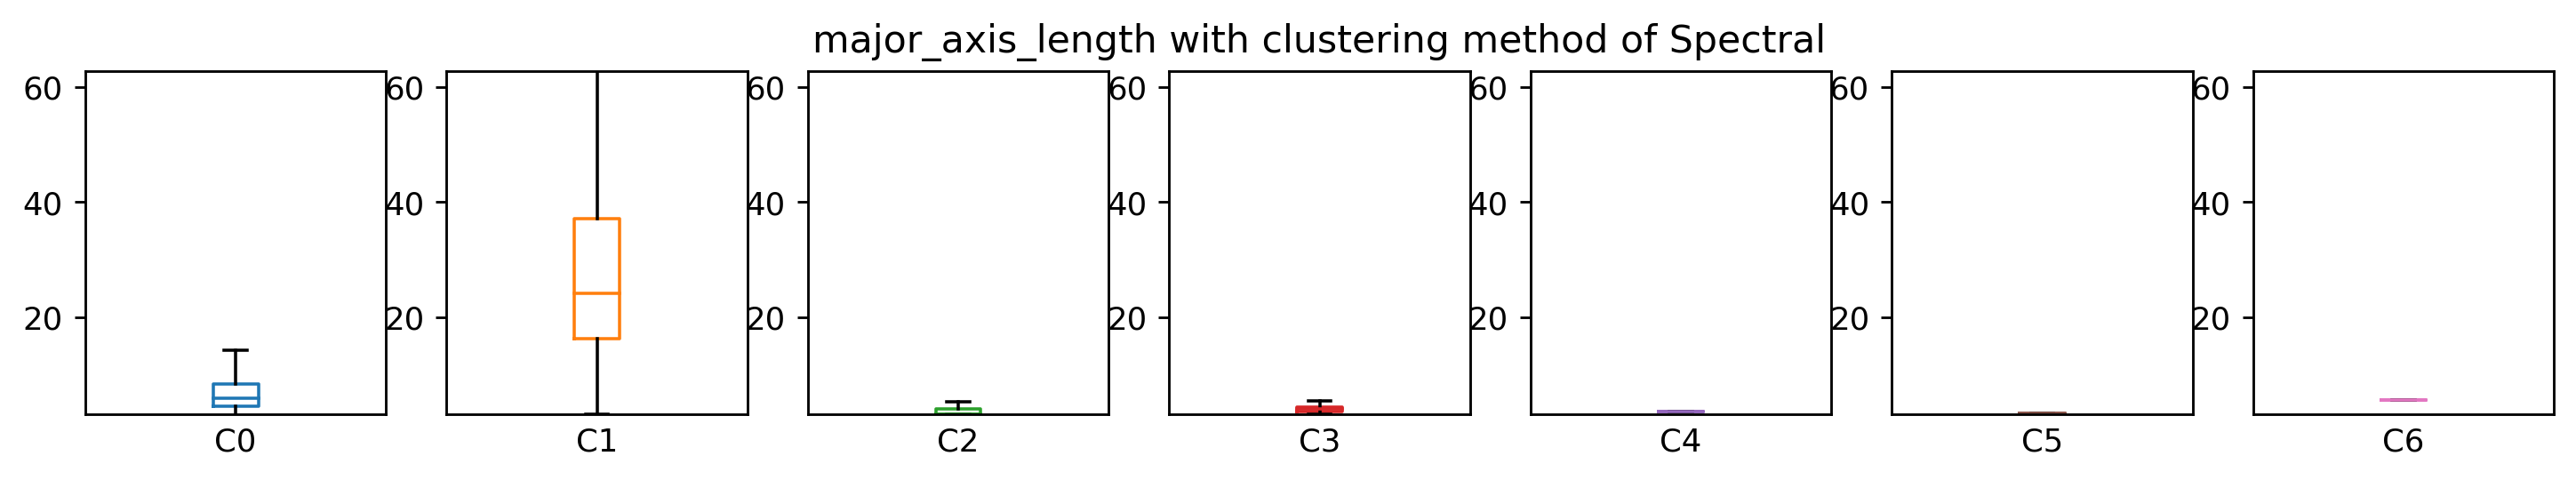

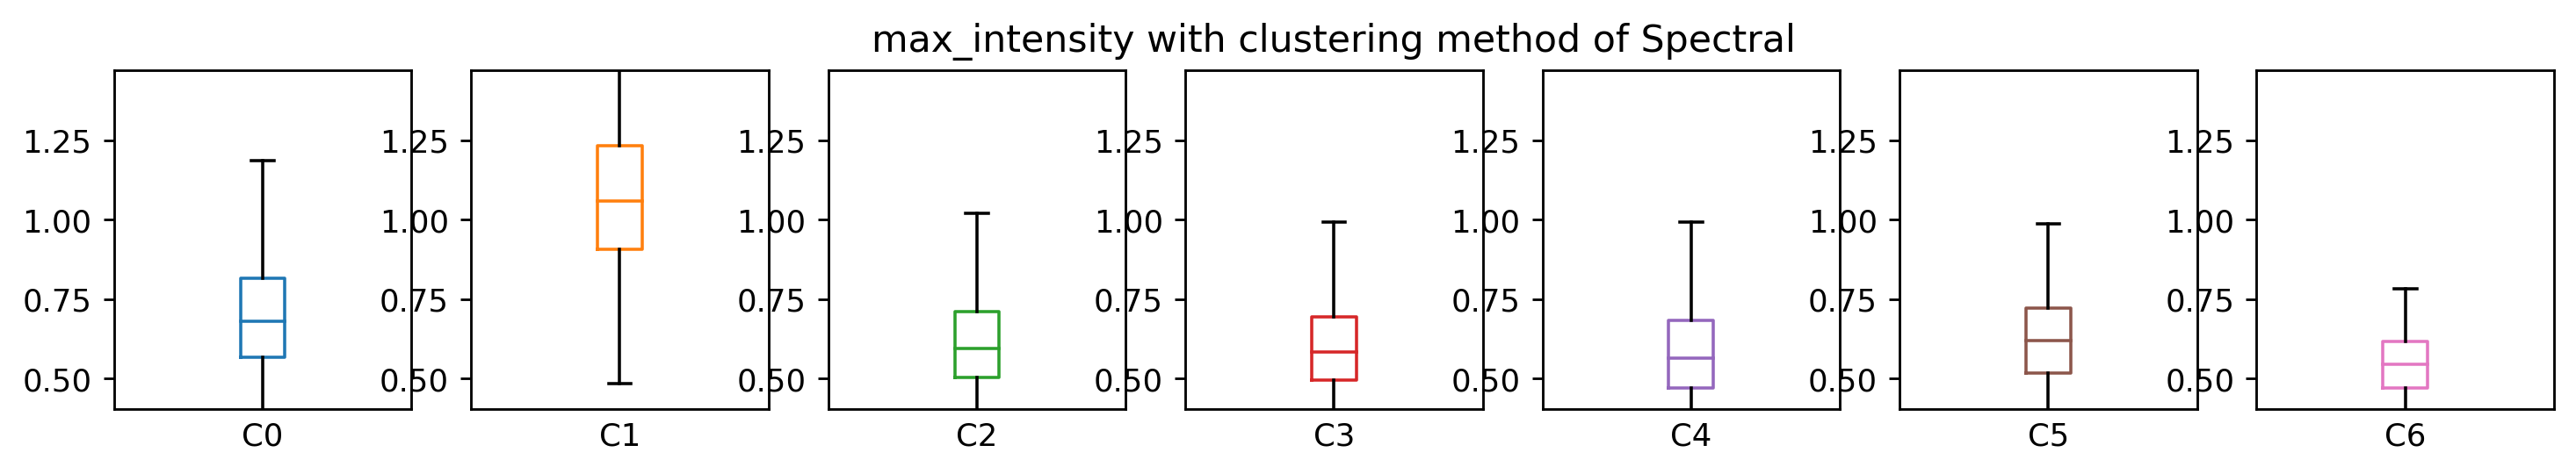

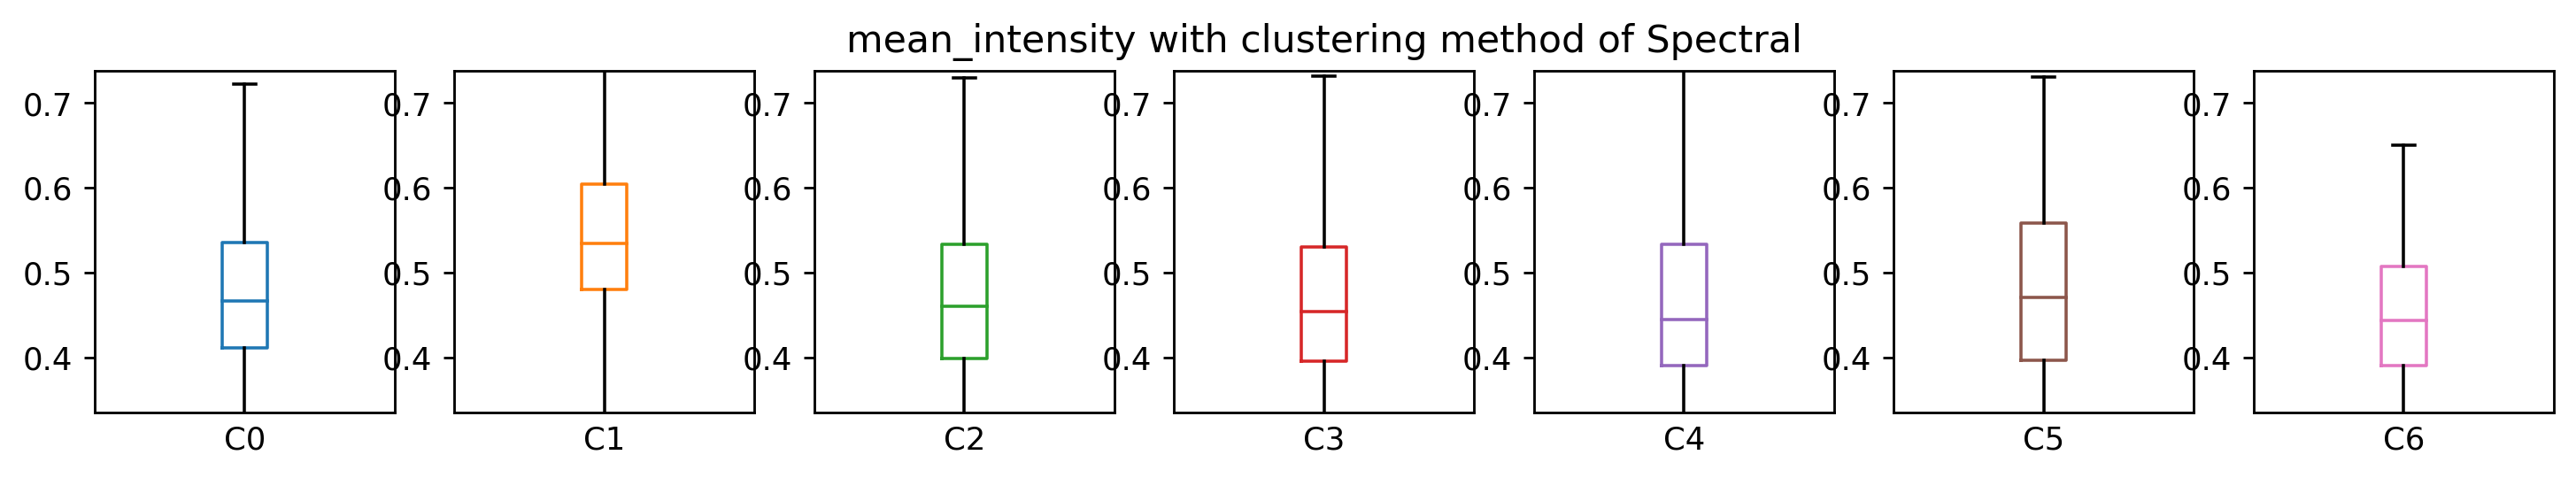

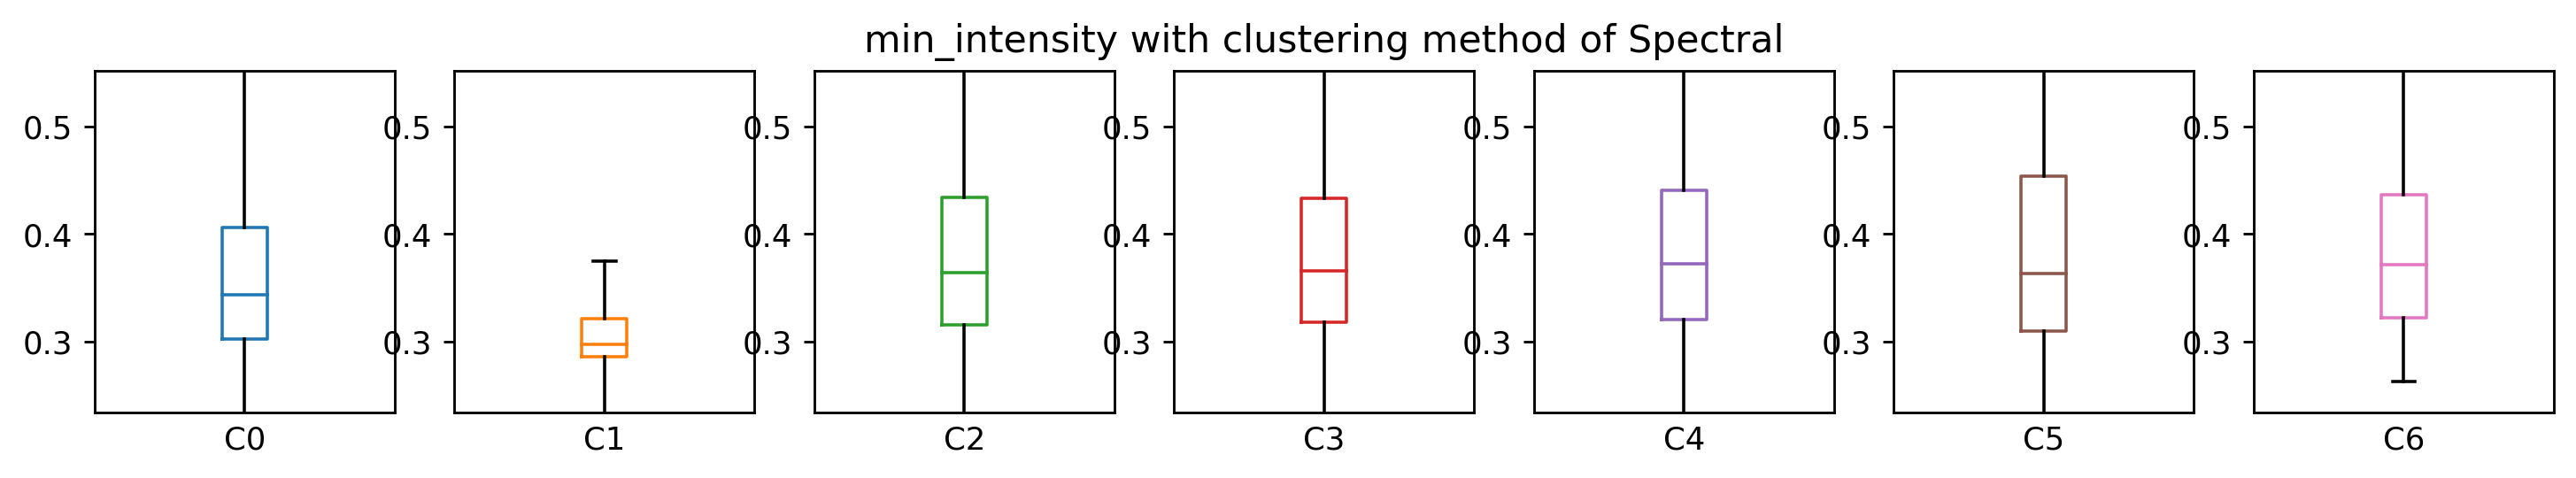

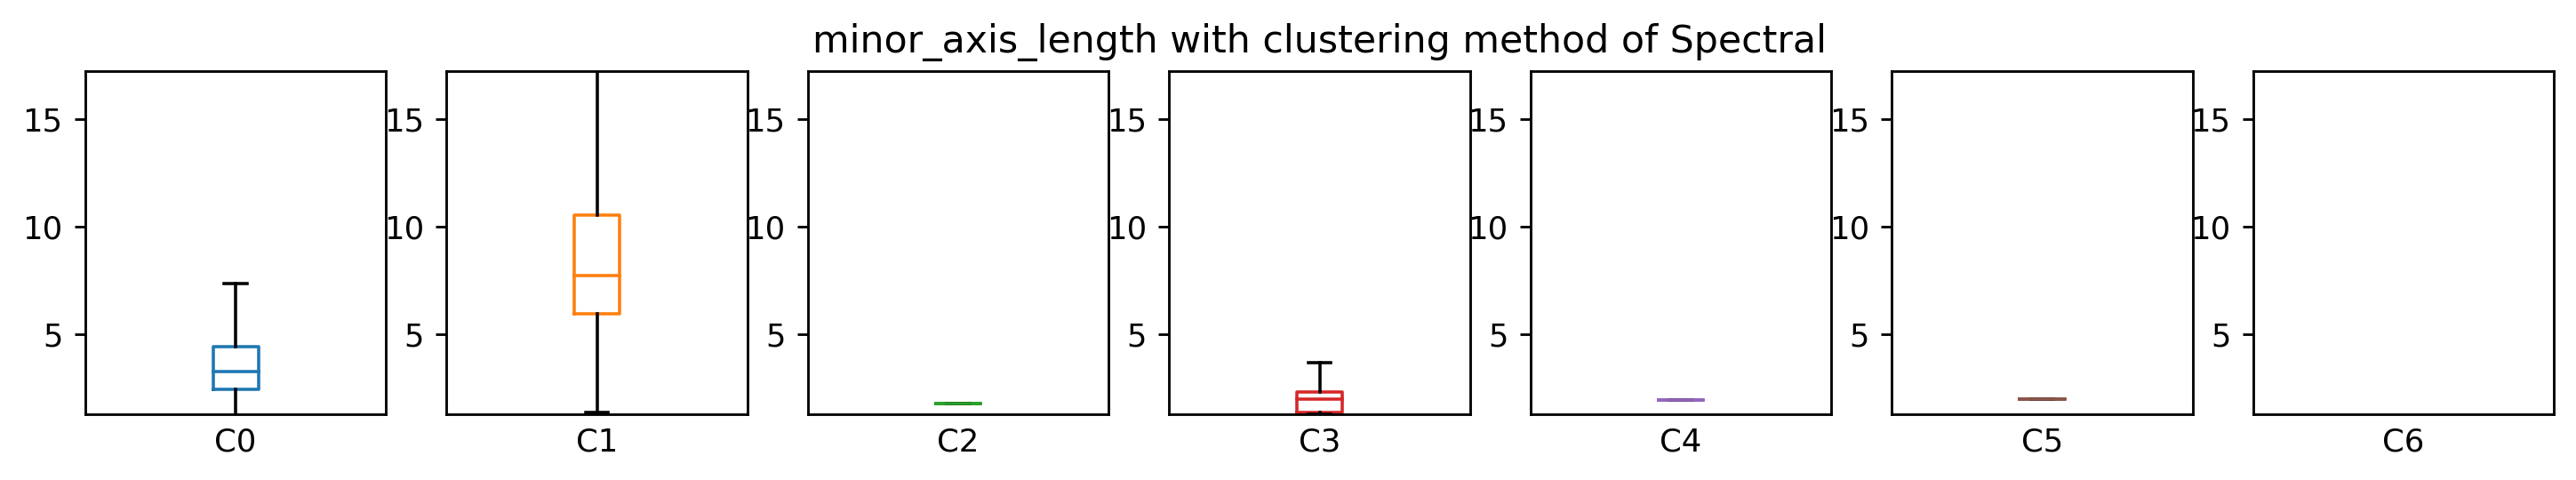

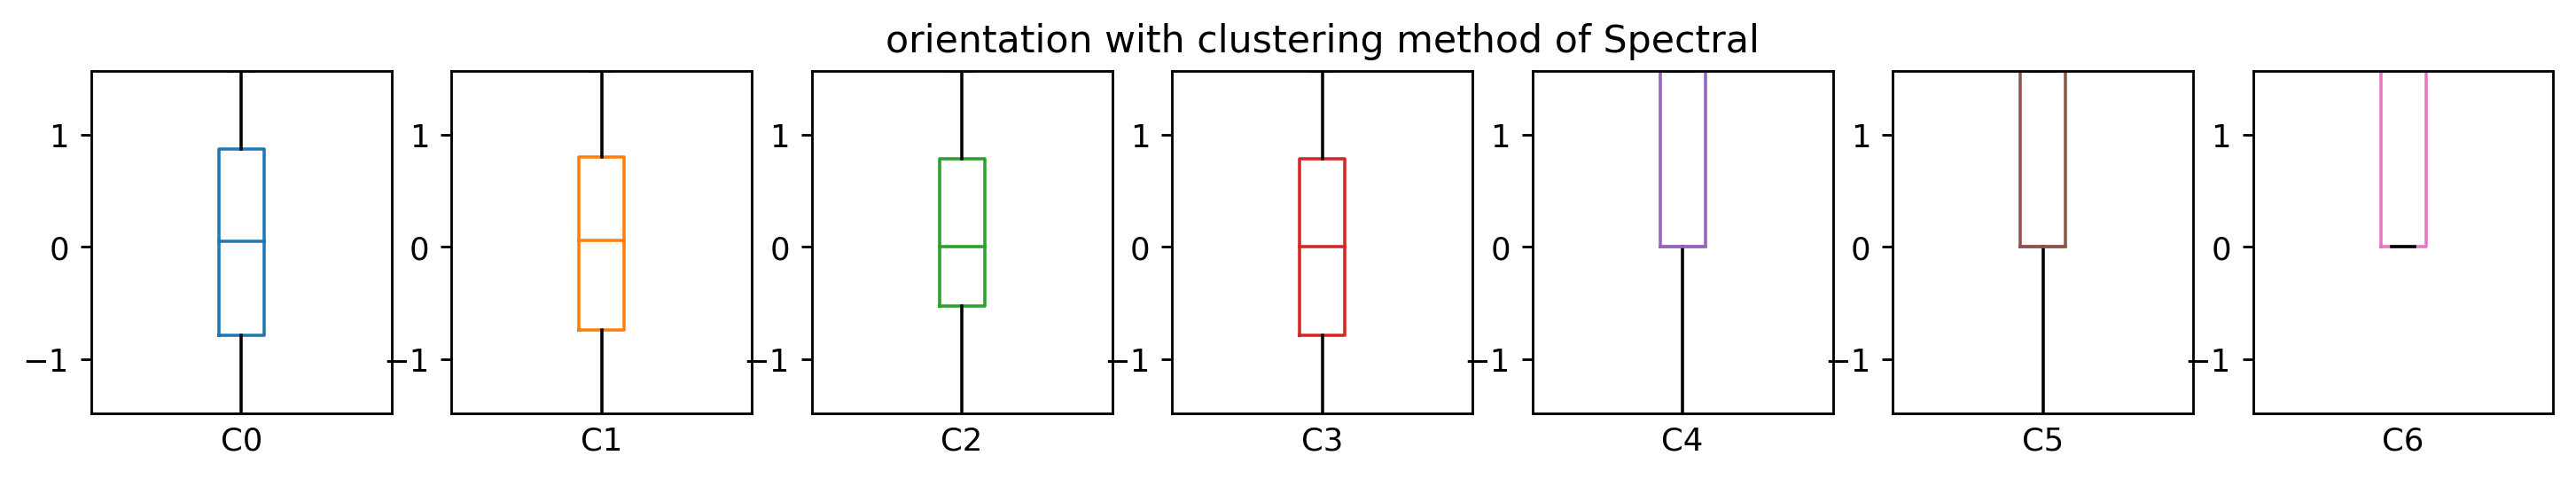

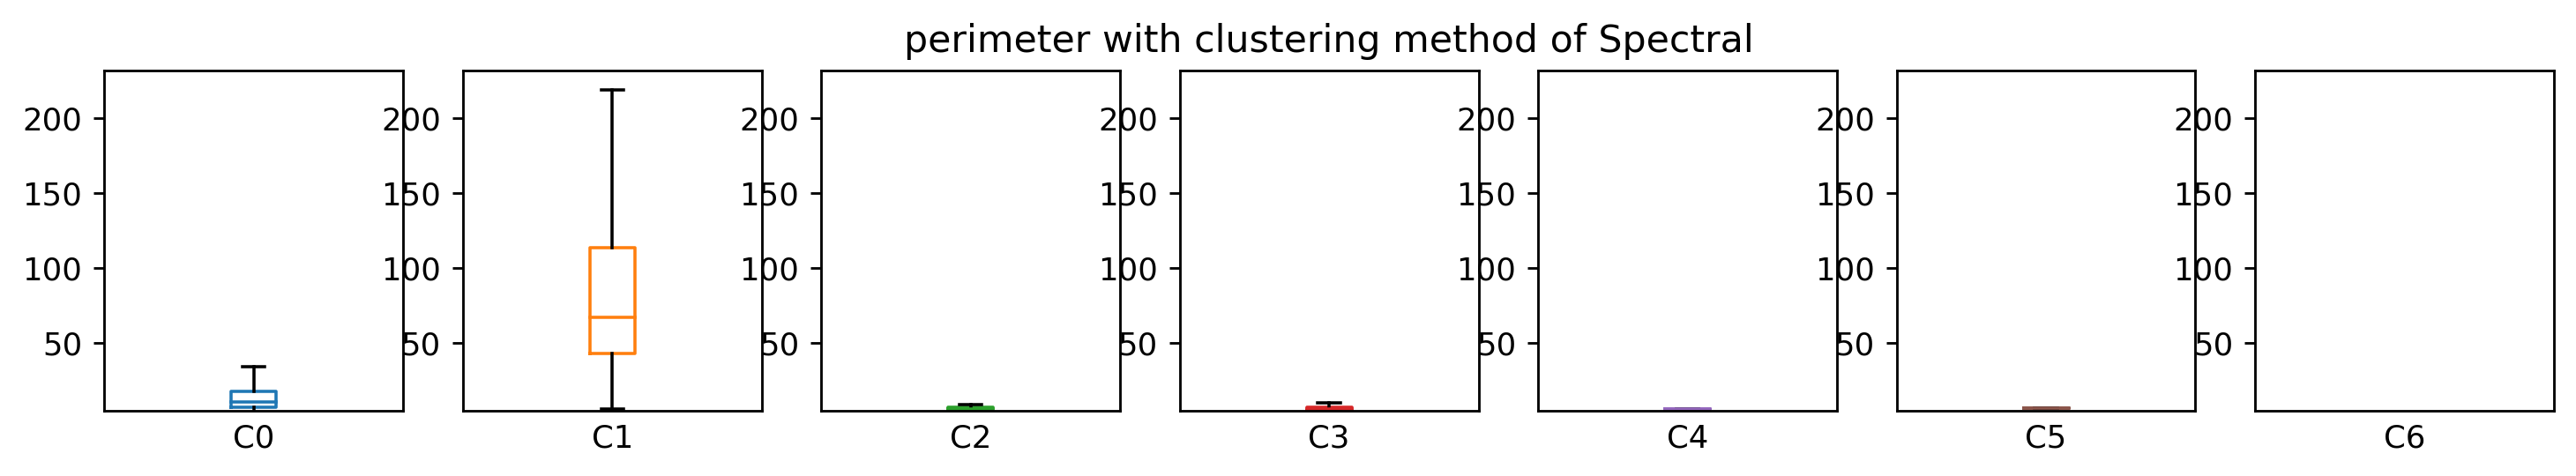

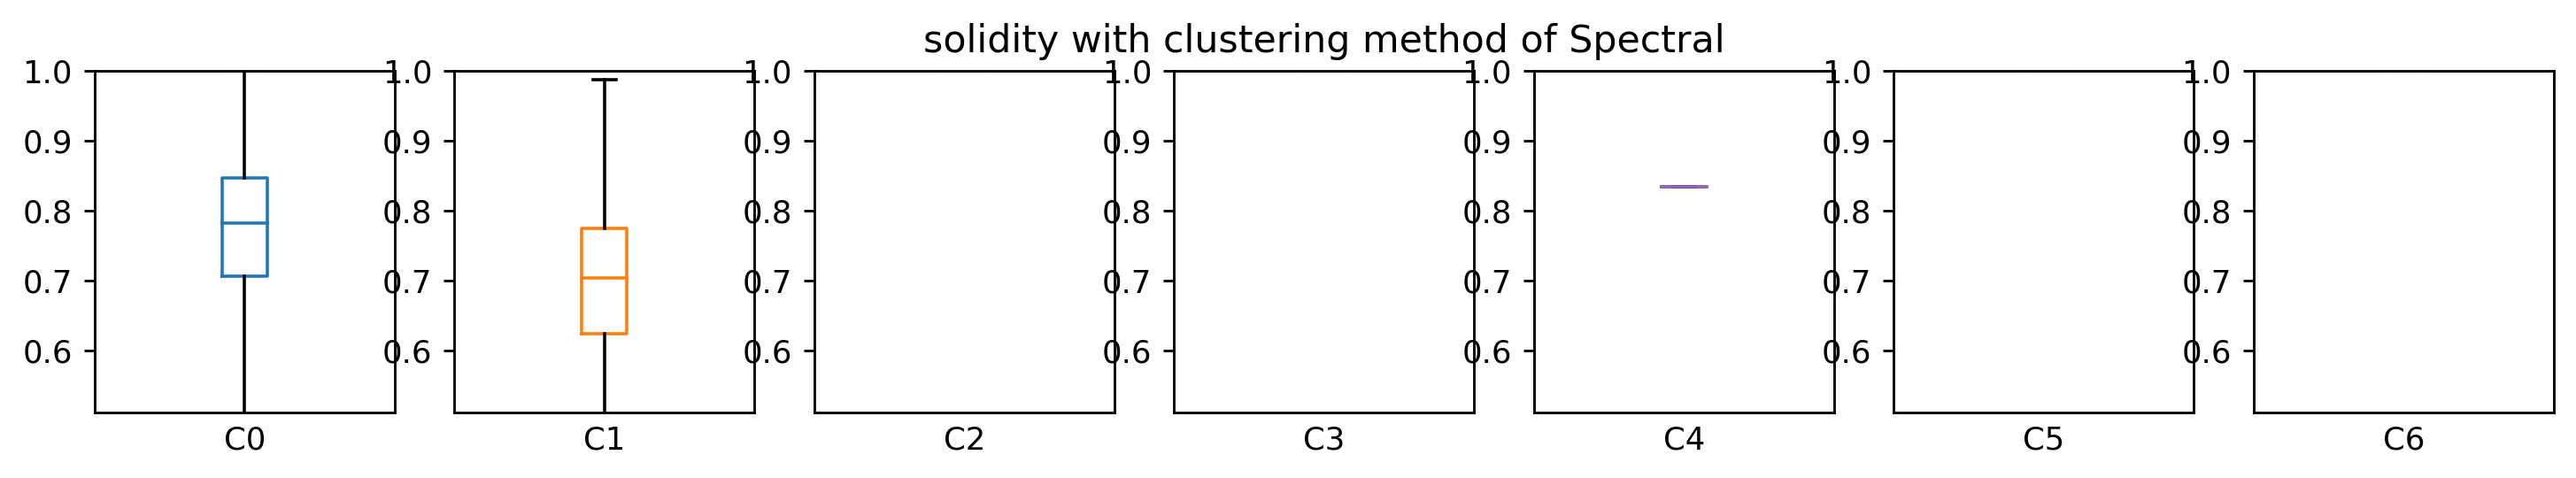

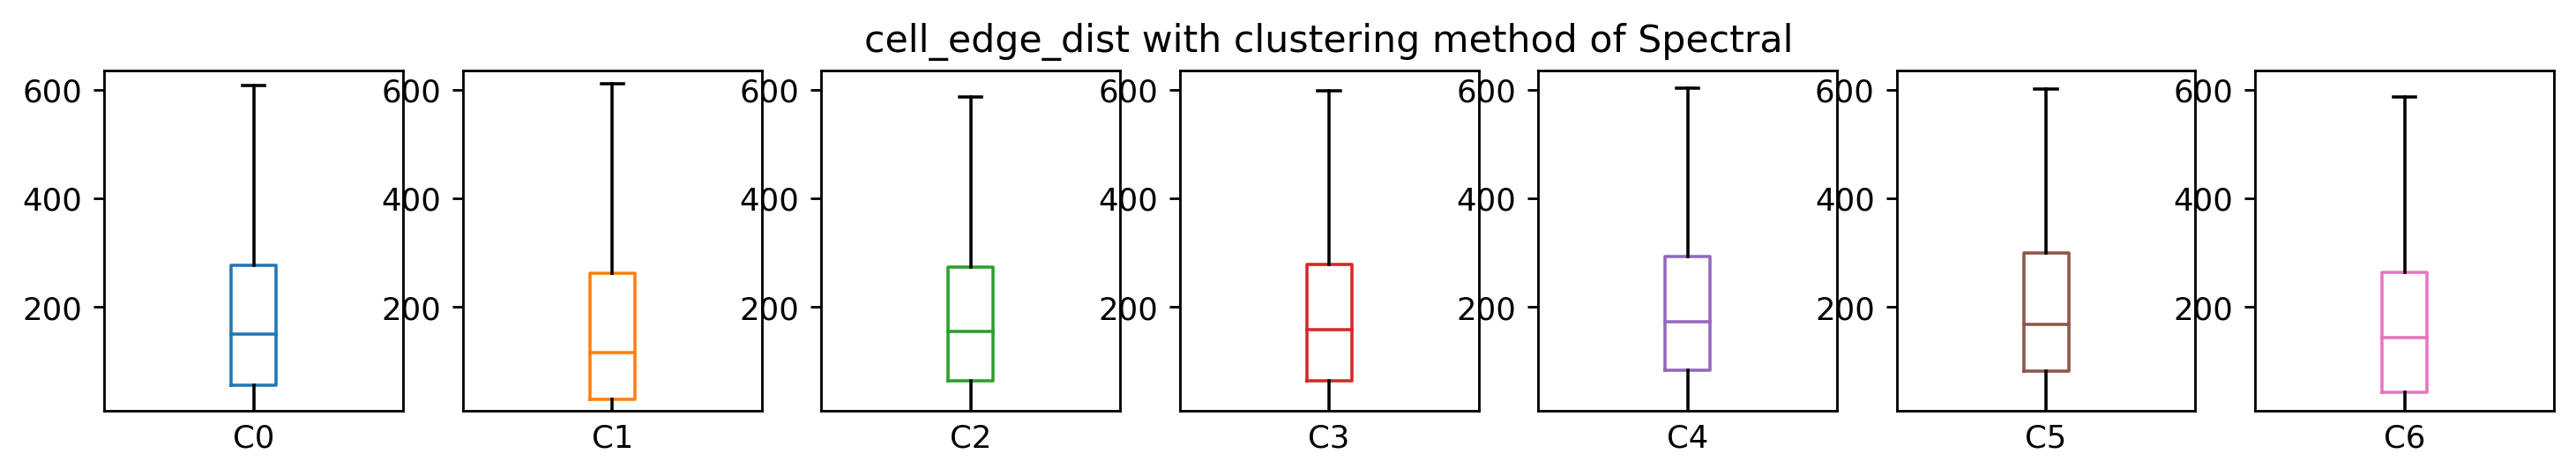

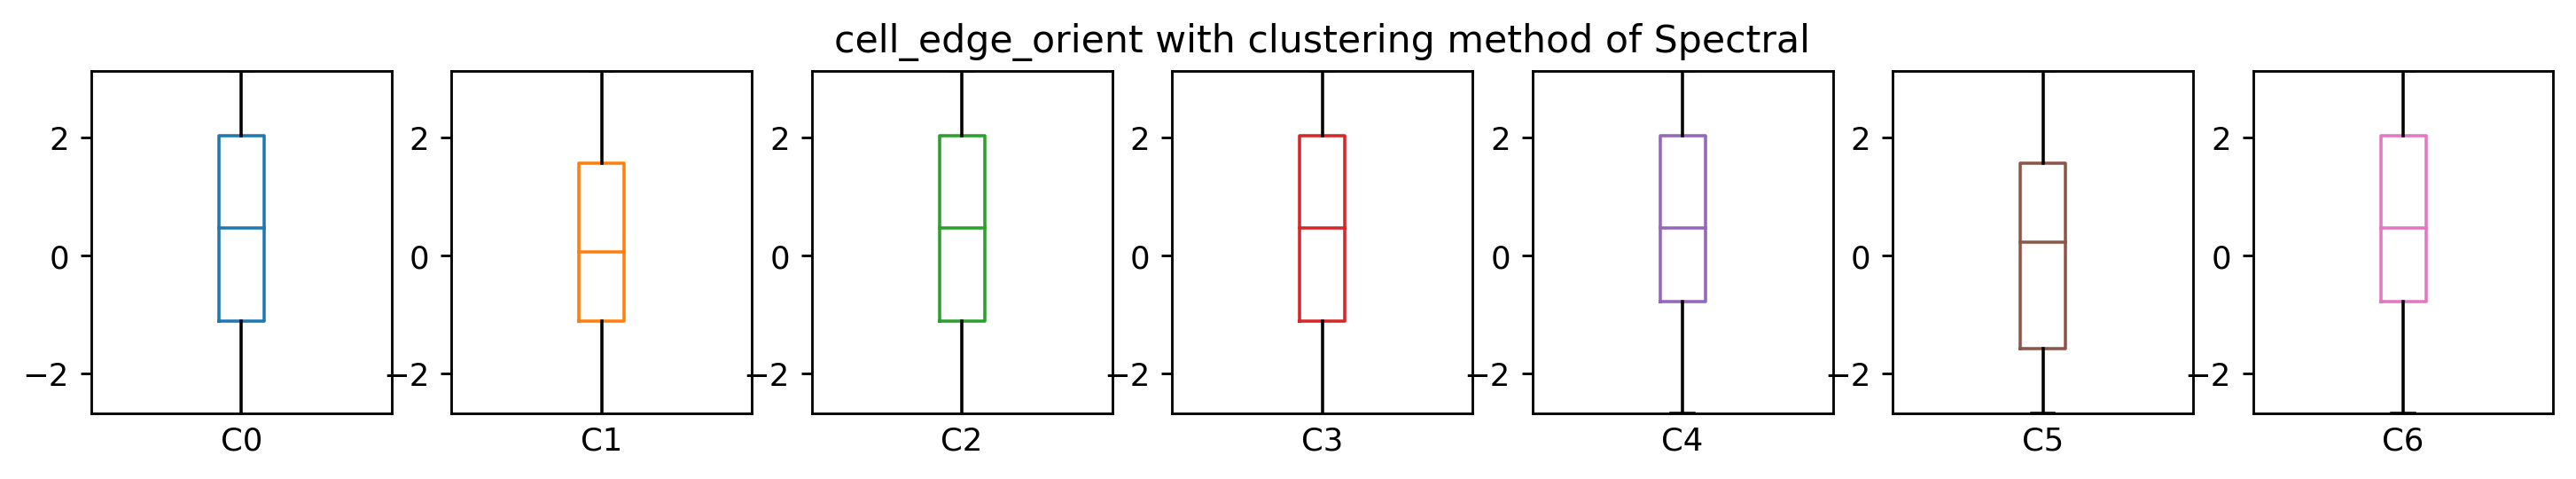

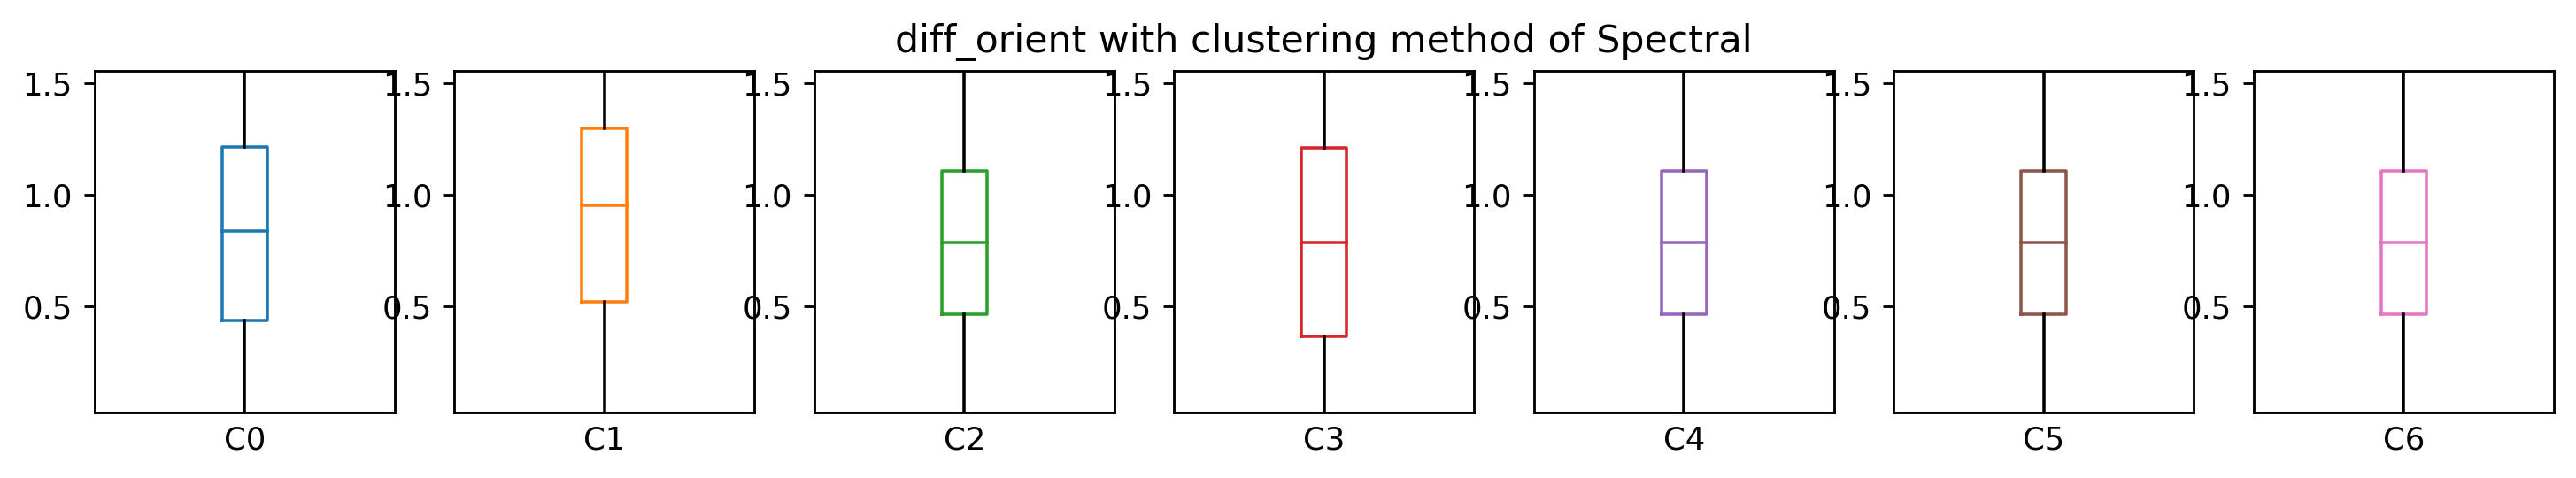

In [6]:
for clusterMed in ['MiniBatc','Spectral']:
   for featureName in columns:   
        fig, ax = plt.subplots(1, 7, figsize=(14,2), dpi=256, facecolor='w', edgecolor='k')

        for i in range(7):
            AA =prop_df_pax_all[prop_df_pax_all['cluster_ID_'+clusterMed]==i]
            boxfig = ax[i].boxplot(AA[featureName],showfliers=False,boxprops={'color':newmap.colors[i+1,:]})
            ax[i].set_ylim([np.percentile(prop_df_pax_all[featureName],2),np.percentile(prop_df_pax_all[featureName],98)])
            ax[i].set_xlabel('C'+str(i))
            ax[i].set_xticks(())
            for median in boxfig['medians']:
                median.set_color(newmap.colors[i+1,:])
        ax[3].set_title(featureName + ' with clustering method of ' +clusterMed )

        fig.savefig(os.path.join('/mnt/d/lding/FA/analysis_results/static_clustering_stats', 'VB_stat_'+featureName + '_' +clusterMed+'.png'))
            

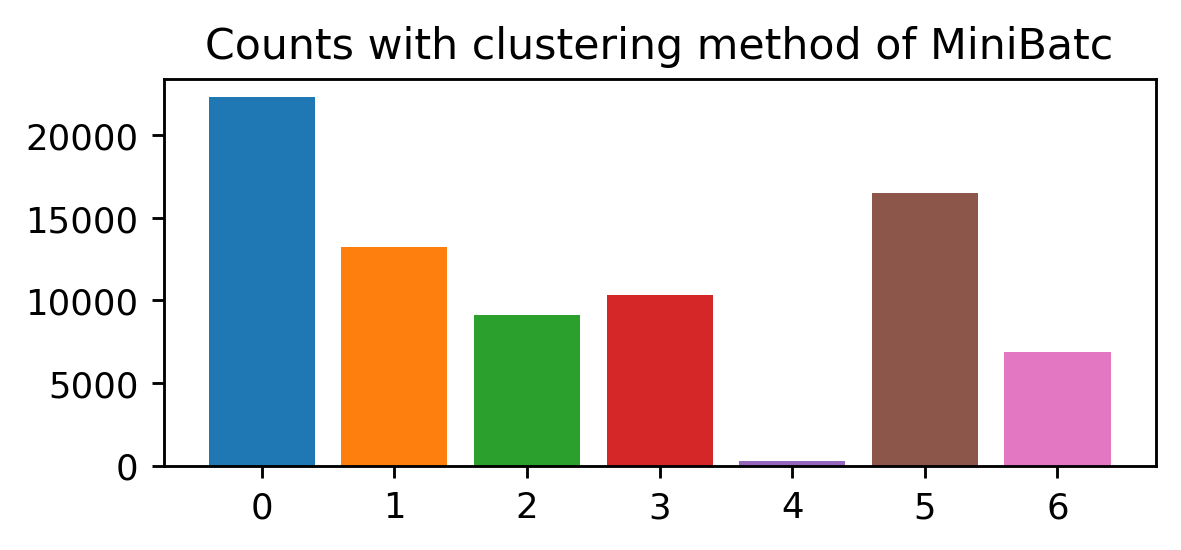

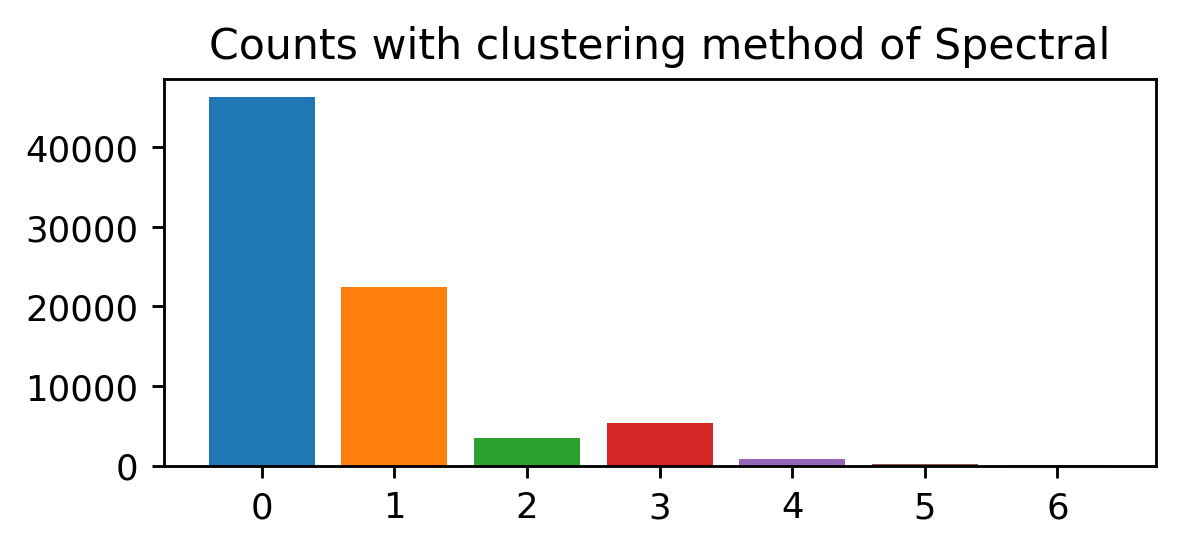

In [7]:
for clusterMed in ['MiniBatc','Spectral']:
    fig = plt.figure(figsize=(5,2), dpi=256, facecolor='w', edgecolor='k')

    hist_array = np.histogram(prop_df_pax_all['cluster_ID_'+clusterMed], 7)
    plt.bar([0,1,2,3,4,5,6],hist_array[0],color=newmap.colors[1:8,:])

    # plt.hist(prop_df_pax_all['cluster_ID_'+clusterMed],7,color=newmap.color)    
    plt.title('Counts with clustering method of ' +clusterMed )

    fig.savefig(os.path.join('/mnt/d/lding/FA/analysis_results/static_clustering_stats', 'VB_stat_no_' +clusterMed+'.png'))
        

In [ ]:
prop_df_pax_all

In [87]:
hist_array[1]

array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
       4.28571429, 5.14285714, 6.        ])

In [83]:
hist_array[0]


array([11117, 15429,  4422, 19613, 22443,  5328,   297])

In [53]:
featureName

'filename'

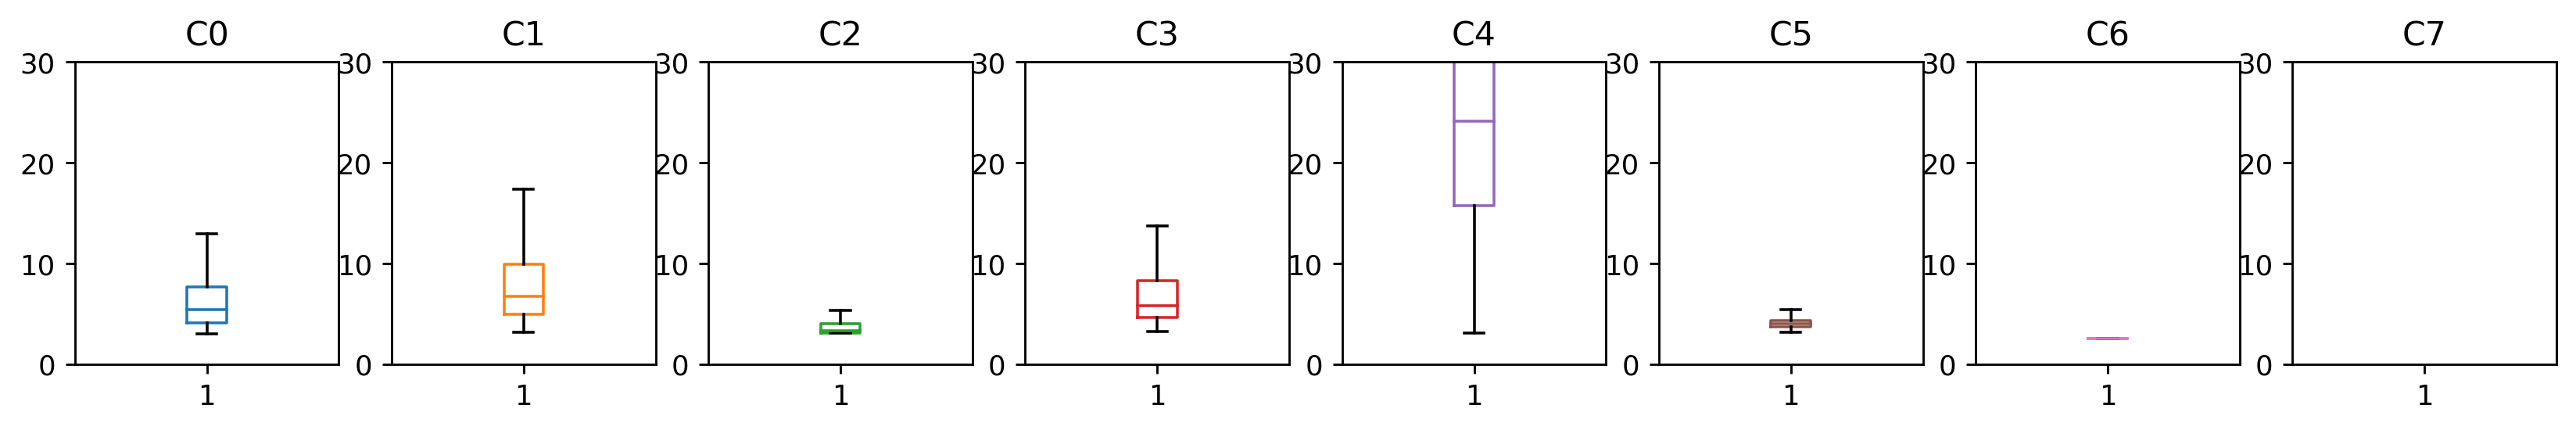

In [26]:


fig, ax = plt.subplots(1, 8, figsize=(16,2), dpi=256, facecolor='w', edgecolor='k')

for i in range(8):
    AA =prop_df_pax_all[prop_df_pax_all['cluster_ID_MiniBatc']==i]
    boxfig = ax[i].boxplot(AA['major_axis_length'],showfliers=False,boxprops={'color':newmap.colors[i+1,:]})
    ax[i].set_ylim([0, 30])
    ax[i].title.set_text('C'+str(i))
    for median in boxfig['medians']:
        median.set_color(newmap.colors[i+1,:])

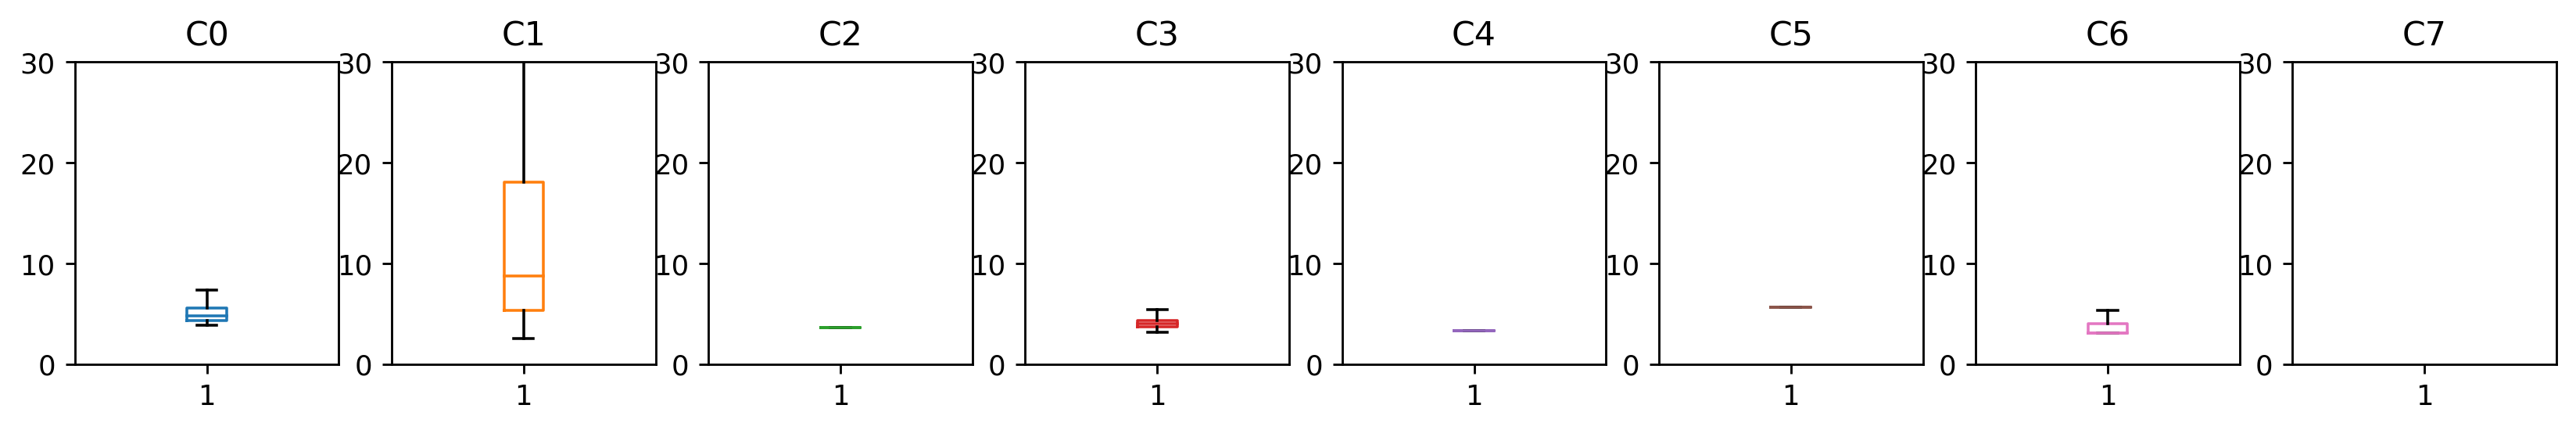

In [27]:
fig, ax = plt.subplots(1, 8, figsize=(16,2), dpi=256, facecolor='w', edgecolor='k')

for i in range(8):
    AA =prop_df_pax_all[prop_df_pax_all['cluster_ID_Spectral']==i]
    boxfig = ax[i].boxplot(AA['major_axis_length'],showfliers=False,boxprops={'color':newmap.colors[i+1,:]})
    ax[i].set_ylim([0, 30])
    ax[i].title.set_text('C'+str(i))
    for median in boxfig['medians']:
        median.set_color(newmap.colors[i+1,:])

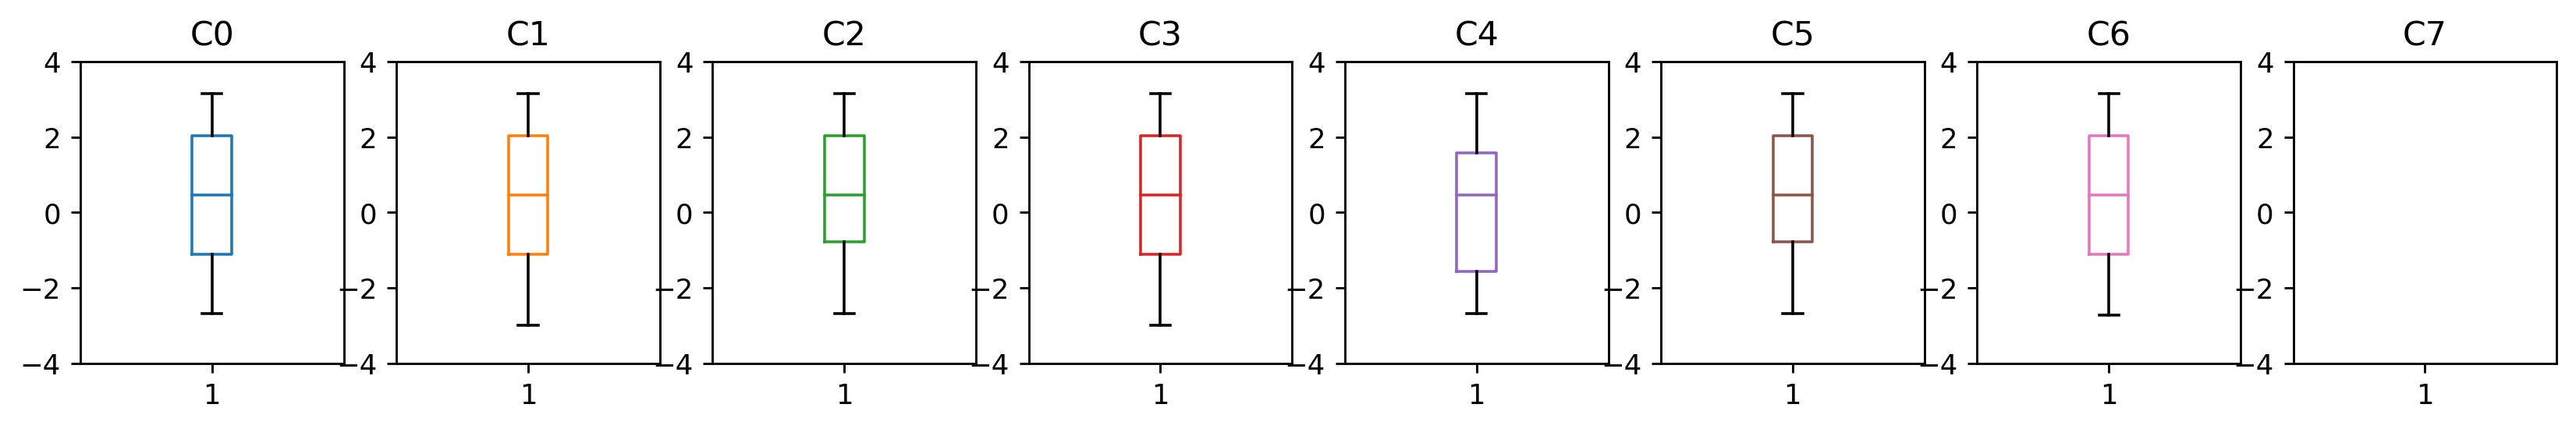

In [30]:
fig, ax = plt.subplots(1, 8, figsize=(16,2), dpi=256, facecolor='w', edgecolor='k')

for i in range(8):
    AA =prop_df_pax_all[prop_df_pax_all['cluster_ID_Spectral']==i]
    boxfig = ax[i].boxplot(AA['cell_edge_orient'],showfliers=False,boxprops={'color':newmap.colors[i+1,:]})
    ax[i].set_ylim([-4,4])
    ax[i].title.set_text('C'+str(i))
    for median in boxfig['medians']:
        median.set_color(newmap.colors[i+1,:])

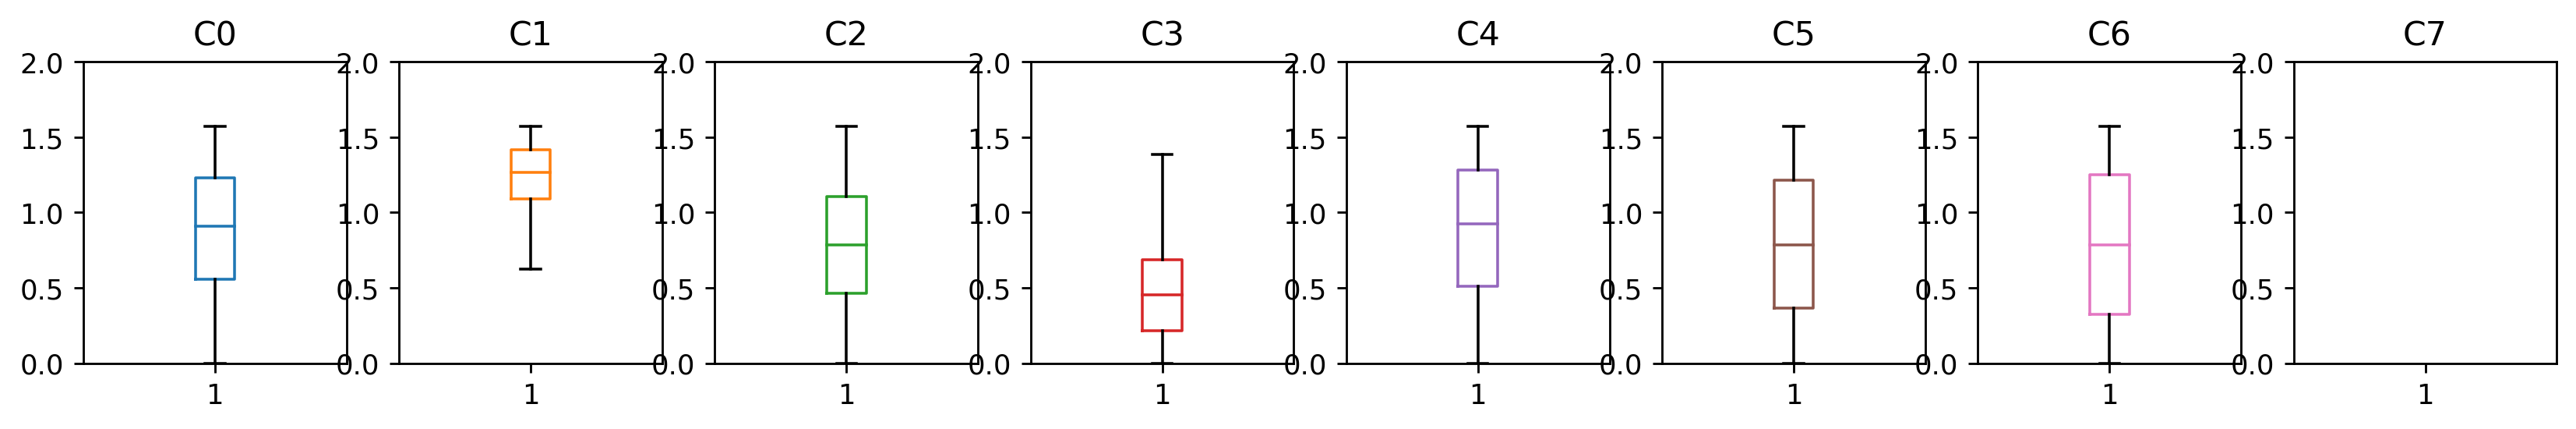

In [33]:
fig, ax = plt.subplots(1, 8, figsize=(16,2), dpi=256, facecolor='w', edgecolor='k')

for i in range(8):
    AA =prop_df_pax_all[prop_df_pax_all['cluster_ID_MiniBatc']==i]
    boxfig = ax[i].boxplot(AA['diff_orient'],showfliers=False,boxprops={'color':newmap.colors[i+1,:]})
    ax[i].set_ylim([0,2])
    ax[i].title.set_text('C'+str(i))
    for median in boxfig['medians']:
        median.set_color(newmap.colors[i+1,:])


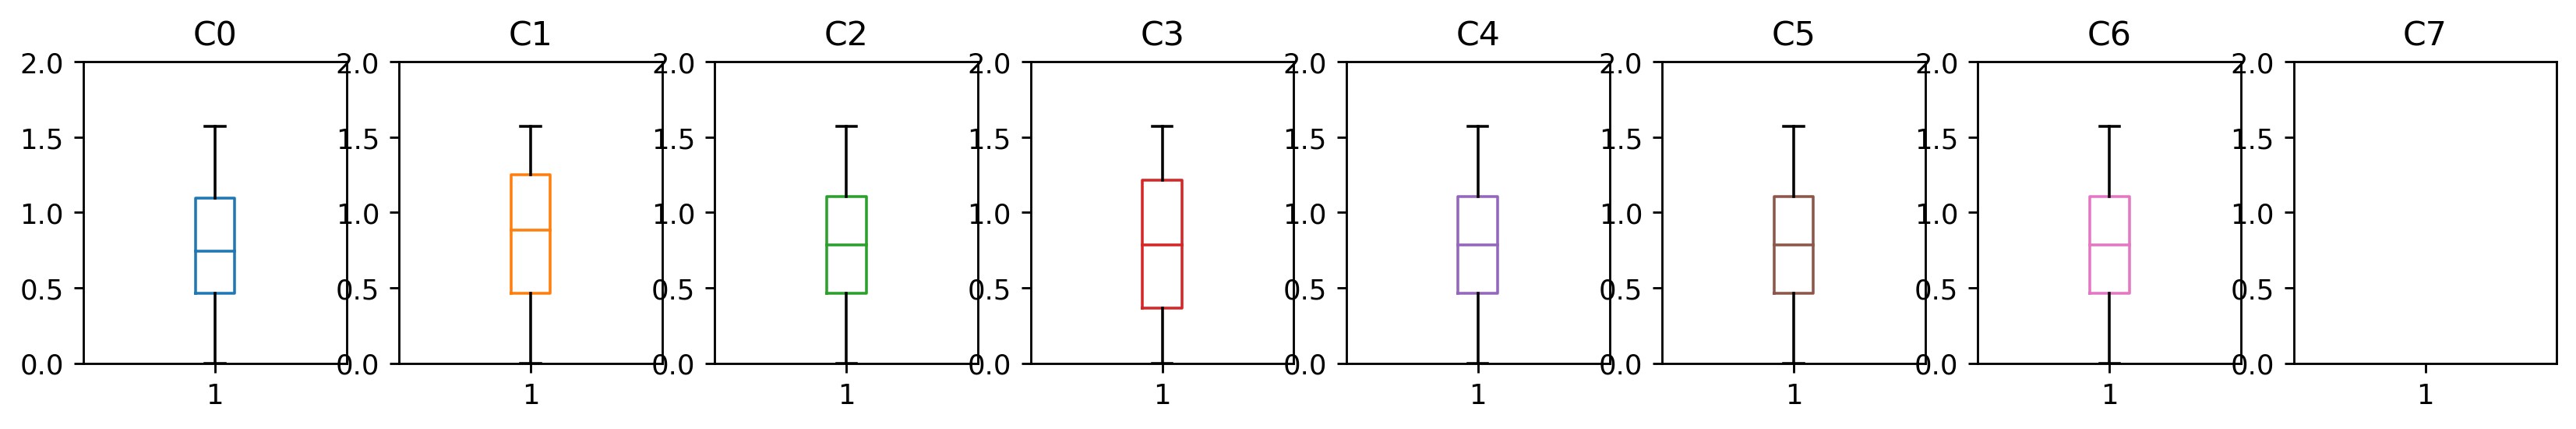

In [34]:
fig, ax = plt.subplots(1, 8, figsize=(16,2), dpi=256, facecolor='w', edgecolor='k')

for i in range(8):
    AA =prop_df_pax_all[prop_df_pax_all['cluster_ID_Spectral']==i]
    boxfig = ax[i].boxplot(AA['diff_orient'],showfliers=False,boxprops={'color':newmap.colors[i+1,:]})
    ax[i].set_ylim([0,2])
    ax[i].title.set_text('C'+str(i))
    for median in boxfig['medians']:
        median.set_color(newmap.colors[i+1,:])
